# Bipolar Disorder and Mood Stabilisers:

### An NLP exploration of the two main subtypes of bipolar disorder with regards to Reddit posts on mood stabilisers

# Contents (Part 2)

- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Natural Language Processing](#Natural-Language-Processing)

# Exploratory Data Analysis

A number of analyses can be done on the data to generate insights and understand the data to be modelled.

## Importing necessary libraries

The libraries below will be used in this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

from matplotlib.ticker import PercentFormatter
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Overrides Matplotlib theme with Seaborn's 
sns.set(font_scale = 1.2)
sns.set_context('talk')

# Enables Pandas to display all the columns
pd.set_option('display.max_columns', None)

# Enables Pandas to display all the rows
pd.set_option('display.max_rows', None)

# Enables Pandas to display more text in a column
pd.set_option('display.max_colwidth', 1000)

## Loading the data 

The cleaned data is loaded. 

In [2]:
sb = pd.read_csv('../data/sb_med.csv')

In [3]:
sb.head()

,author,author_flair_text,created_utc,id,link_flair_text,num_comments,selftext,title,datetime
0,blessedindigo,NaN,1638685519,r99g1m,Med Question,1,"Aside from the rash, what undesired side effects caused you to try something else?",Those who've tried Lamictal but it wasn't the right medication for you..,2021-12-05 06:25:19
1,Hairy-Mirror-6020,NaN,1638684996,r99b9u,General,1,"i’m scared there’s no hope , ive tried prozac, zoloft, effexor, lexapro, paxil, wellbutrin, abilify , and parnate. i’m back on prozac now and today i just started 25 mg lamictal . i feel so alone and empty every day , i just wish i could be happy","is there any hope for me , just started lamictal today . my last manic episode was a year ago and i’ve been depressed ever since",2021-12-05 06:16:36
2,YasmeenMaria,NaN,1638671873,r95iys,Med Question,1,"Kia ora, hello! I am taking pregabalin for chronic neck pain...lamictal, quetiapine, and sertraline for bipolar. Can pregabalin induce mania?? I can't find any decent articles online, but seriously feel this stuff is wild. I'm getting wild. Its supposed to be good for bipolar. I wonder if it is inducing mania due to the condition, or if it is a side effect anyone without bipolar could also have? Has anyone else experienced this?",Please help PREGABALIN,2021-12-05 02:37:53
3,Shifty-Manzanita,NaN,1638668704,r94kck,Med Question,1,"I was wondering if anyone takes either lamictal or lexapro and gets hot and sweaty quicker than most? I’m not sure if it’s my meds or just me. I can’t remember if I used to be this way before meds. Also… definitely sure it’s not anxiety. Any exercises I do this happens. Even if its just a simple task at home. Ugh! Example… I am a Jiu Jitsu practitioner. I get super hot, red, and sweat like mad way before anyone else. It’s embarrassing as hell. But I still go anyway. I’m just looking to see if anyone else has this issue on meds as well. Anyone?",Easily get hot and sweaty,2021-12-05 01:45:04
4,Lipbanging,NaN,1638665638,r93n5l,Med Question,1,"Down for the count in November with a mixed episode. Horrible depression, racing thoughts, couldn’t stop cutting myself, had to get stitches, super impulsive, hearing voices telling me to kill myself, paranoid. Psychiatrist made me go to the hospital to get admitted. Another psych ward stay. Which brings my total to lucky number 13. I was taken off abilify and put on zyprexa. I was skeptical at first but omg I am starting to feel so much better. Yesterday and today especially I feel like myself again. Maybe this could be the magical combination everyone keeps talking about. I’m still hesitant but hopeful which is encouraging because I couldn’t tell you the last time I had any kind of hope. Lithium, depakote, zyprexa. I promise to keep taking you if you promise to keep working. 🤞🏻🤞🏻 I hope you all are doing ok too. What’s your magical combination?",Have you found the one?,2021-12-05 00:53:58


The shapes of the DataFrame is as follows:

In [4]:
sb.shape

(21939, 9)

The null values in the DataFrames are as follows:

In [5]:
sb.isna().sum()

author                   0
author_flair_text    17657
created_utc              0
id                       0
link_flair_text      12638
num_comments             0
selftext              1045
title                    0
datetime                 0
dtype: int64

The null values will be filled with 'None' for the 'author_flair_text' and 'link_flair_text' columns, and an empty string for the remaining 'selftext' column.

In [6]:
sb['author_flair_text'].fillna('None', inplace=True)
sb['link_flair_text'].fillna('None', inplace=True)
sb.fillna('', inplace=True)

There are no more null values in the DataFrame.

In [7]:
sb.isna().sum()

author               0
author_flair_text    0
created_utc          0
id                   0
link_flair_text      0
num_comments         0
selftext             0
title                0
datetime             0
dtype: int64

## Focusing the scope of the data

We will only look at the part of the data where the post authors have voluntarily declared their bipolar subtype. This can be found under the `author_flair_text`.

In [8]:
sb = sb[(sb['author_flair_text'] == 'Bipolar 1') | 
        (sb['author_flair_text'] == 'Bipolar 2')]

The data is now as follows. These will also be the two classes for future modelling. 

In [9]:
sb['author_flair_text'].value_counts()

Bipolar 2    1436
Bipolar 1    1064
Name: author_flair_text, dtype: int64

## Creating some new columns

### Combining `title` with `selftext`

We will create a new column called `text` where the title is combined with the selftext.

In [10]:
# A space is added in between to make sure we don't fuse any words together.
sb['text'] = sb['title'] + ' ' + sb['selftext']

We will also create a new column for the number of words in the `text` column.

In [11]:
# Splits the text at each word in the text, and finds the number of words in the resulting list.
sb['text_num_words'] = sb['text'].map(lambda text: len(text.split()))

### Number of words in the `title` 

We will create a column for the number of words in the title.

In [12]:
# Splits the text at each word in the title, and finds the number of words in the resulting list.
sb['title_num_words'] = sb['title'].map(lambda text: len(text.split()))

### Number of words in the `selftext` 

We will create the new column as follows:

In [13]:
# Splits the text at each word in the selftext, and finds the number of words in the resulting list.
sb['selftext_num_words'] = sb['selftext'].map(lambda text: len(text.split()))

### Dates and Times 

We can create more columns to indicate dates and times.

In [14]:
sb['datetime'] = pd.to_datetime(sb['datetime'])
sb['year_'] = sb['datetime'].apply(lambda x: x.year)
sb['month_'] = sb['datetime'].apply(lambda x: x.month)
sb['day_'] = sb['datetime'].apply(lambda x: x.day)
sb['week_'] = sb['datetime'].apply(lambda x: x.week)
sb['day_of_week_'] = sb['datetime'].apply(lambda x: x.dayofweek)
sb['hour_'] = sb['datetime'].apply(lambda x: x.hour)

### VADER Sentiment scores 

VADER (Valence Aware Dictionary for Sentiment Reasoning) is a pre-trained model trained on social media that can assign sentiment scores to each post ([*source*](https://github.com/cjhutto/vaderSentiment)). Reddit is a form of social media, and hence this model will be suitable here. First, a function is made to add the sentiment score to each submission.

In [15]:
def scores(sb):
    sia = SIA()
    pol_score = sia.polarity_scores(sb['text'])
    return sb.append(pd.Series(list(pol_score.values()), index=pol_score.keys()))

The function is then applied to the submissions:

In [16]:
sb = sb.apply(scores, axis=1)

Some new columns are created.

In [17]:
sb.columns

Index(['author', 'author_flair_text', 'created_utc', 'id', 'link_flair_text',
       'num_comments', 'selftext', 'title', 'datetime', 'text',
       'text_num_words', 'title_num_words', 'selftext_num_words', 'year_',
       'month_', 'day_', 'week_', 'day_of_week_', 'hour_', 'neg', 'neu', 'pos',
       'compound'],
      dtype='object')

As we do not want the column names to conflict with future possible column names when we vectorise the words in the data, we will rename the column with an additional underscore.

In [18]:
sb.rename(columns={"compound": "compound_"}, inplace=True)

The columns present in the data are now as follows.

In [19]:
sb.columns

Index(['author', 'author_flair_text', 'created_utc', 'id', 'link_flair_text',
       'num_comments', 'selftext', 'title', 'datetime', 'text',
       'text_num_words', 'title_num_words', 'selftext_num_words', 'year_',
       'month_', 'day_', 'week_', 'day_of_week_', 'hour_', 'neg', 'neu', 'pos',
       'compound_'],
      dtype='object')

### Link flair text indicator

The link flair texts are tags that post authors can put on their posts to indicate the topic of the posts. The value counts are as follows. 

In [20]:
sb['link_flair_text'].value_counts()

None                              1631
Med Question                       303
99 Problems/Rant/Story             124
General                            123
General Question                    88
Advice                              55
Discussion Starter                  34
Good News                           22
Suicidal Thoughts Trigger           21
Caution - Suicidal Thoughts         17
Caution - Depression Trigger        15
Dangerous Behavior Warning          14
Meme                                11
Drug Use                            10
Caution - Manic Trigger              9
Art                                  6
Misleading Title                     4
Interesting Link                     2
Caution - Self Harm                  2
Amazeballs                           2
Self-Harm Trigger                    2
General Question/Advice              2
STAR WARS SPOILER                    1
Sexual Abuse Trigger Warning         1
Domestic Abuse Trigger Warning       1
Name: link_flair_text, dt

To simplify the analysis, we will collate general topics into one category, and more serious topics indicating crisis into another. This will be contained in one variable.

In [21]:
# List of flairs for serious topics
serious_flairs = ['Suicidal Thoughts Trigger', 
                 'Caution - Suicidal Thoughts',
                 'Caution - Depression Trigger', 
                 'Dangerous Behavior Warning',
                 'Drug Use', 
                 'Caution - Manic Trigger',
                 'Caution - Self Harm', 
                 'Self-Harm Trigger', 
                 'Sexual Abuse Trigger Warning',
                 'Domestic Abuse Trigger Warning']

In [22]:
# Filling up the column with zeros first, again adding the underscore behind the column name to prevent conflicts
sb['serious_'] = 0

In [23]:
# Change the value in the column to 1 if the posts has a link flair in the list
for flair in serious_flairs:
    sb.loc[sb['link_flair_text'] == flair, 'serious_'] = 1

This is the result.

In [24]:
sb['serious_'].value_counts()

0    2408
1      92
Name: serious_, dtype: int64

## Target column

In anticipation for modelling, we will assign the `author_flair_text` as a new target column, with numbers indicating the respective bipolar type:

In [25]:
sb.loc[(sb['author_flair_text'] == 'Bipolar 1'), 'bp_type'] = 1
sb.loc[(sb['author_flair_text'] == 'Bipolar 2'), 'bp_type'] = 2

In [26]:
sb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 21 to 21924
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   author              2500 non-null   object        
 1   author_flair_text   2500 non-null   object        
 2   created_utc         2500 non-null   int64         
 3   id                  2500 non-null   object        
 4   link_flair_text     2500 non-null   object        
 5   num_comments        2500 non-null   int64         
 6   selftext            2500 non-null   object        
 7   title               2500 non-null   object        
 8   datetime            2500 non-null   datetime64[ns]
 9   text                2500 non-null   object        
 10  text_num_words      2500 non-null   int64         
 11  title_num_words     2500 non-null   int64         
 12  selftext_num_words  2500 non-null   int64         
 13  year_               2500 non-null   int64     

The datatype of the target column will be changed to integer type.

In [27]:
sb['bp_type'] = sb['bp_type'].astype(int)

The type has been changed.

In [28]:
sb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 21 to 21924
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   author              2500 non-null   object        
 1   author_flair_text   2500 non-null   object        
 2   created_utc         2500 non-null   int64         
 3   id                  2500 non-null   object        
 4   link_flair_text     2500 non-null   object        
 5   num_comments        2500 non-null   int64         
 6   selftext            2500 non-null   object        
 7   title               2500 non-null   object        
 8   datetime            2500 non-null   datetime64[ns]
 9   text                2500 non-null   object        
 10  text_num_words      2500 non-null   int64         
 11  title_num_words     2500 non-null   int64         
 12  selftext_num_words  2500 non-null   int64         
 13  year_               2500 non-null   int64     

The initial `author_flair_text` column will be dropped. 

In [29]:
sb.drop(columns='author_flair_text', inplace=True)

The column has been dropped.

In [30]:
'author_flair_text' in sb.columns

False

Below are the value counts of the target column, in raw counts as well as a ratio.

In [31]:
sb['bp_type'].value_counts()

2    1436
1    1064
Name: bp_type, dtype: int64

In [32]:
sb['bp_type'].value_counts(normalize=True)

2    0.5744
1    0.4256
Name: bp_type, dtype: float64

In [33]:
sb.columns

Index(['author', 'created_utc', 'id', 'link_flair_text', 'num_comments',
       'selftext', 'title', 'datetime', 'text', 'text_num_words',
       'title_num_words', 'selftext_num_words', 'year_', 'month_', 'day_',
       'week_', 'day_of_week_', 'hour_', 'neg', 'neu', 'pos', 'compound_',
       'serious_', 'bp_type'],
      dtype='object')

## Creating individual DataFrames for each class

The classes are split into their own DataFrames for easier analysis.

In [34]:
bp1 = sb[sb['bp_type'] == 1].copy()
bp2 = sb[sb['bp_type'] == 2].copy()

## Distribution of Bipolar Types in Dataset

We can visualise the class distribution with a bar chart:

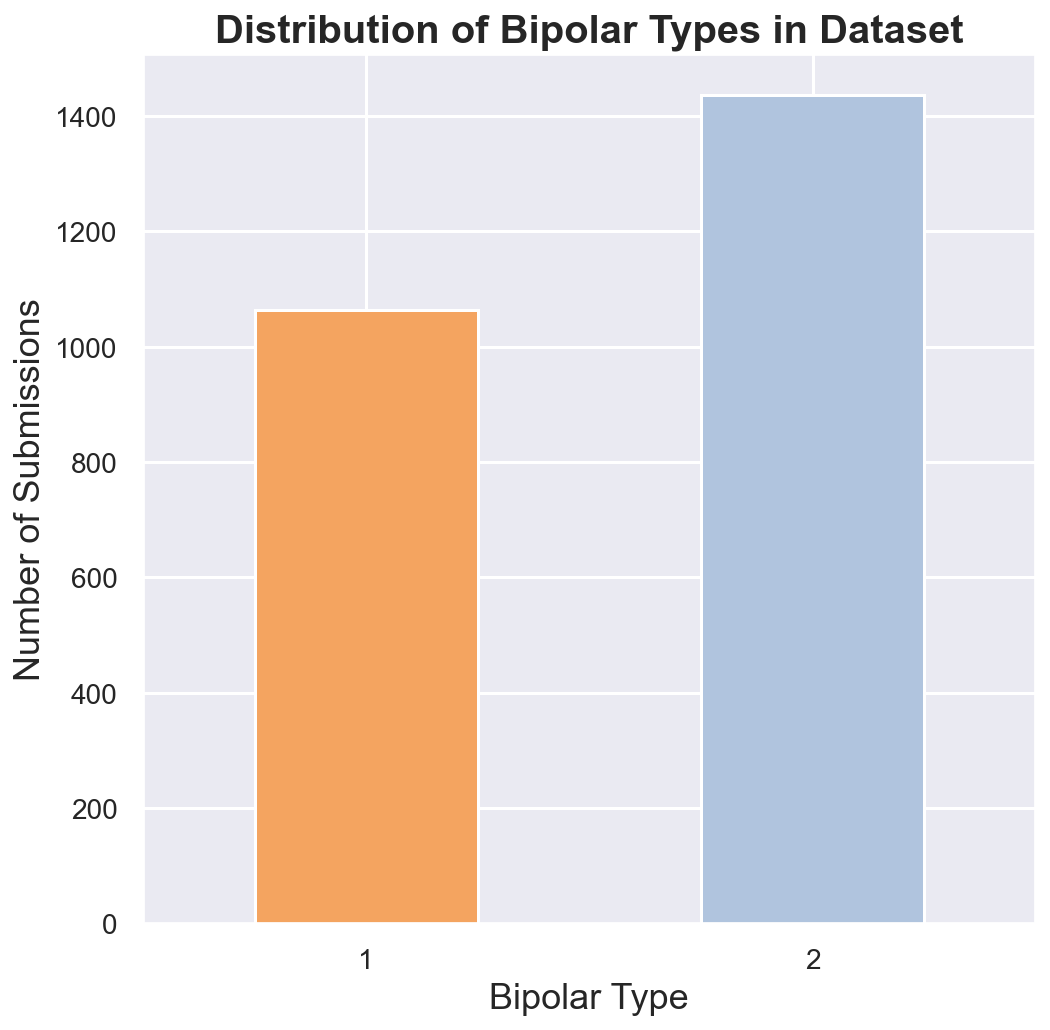

In [35]:
sb['bp_type'].value_counts().sort_values().plot(kind="bar", 
                                                figsize=(8,8),
                                                fontsize=14,
                                                color=['sandybrown', 'lightsteelblue'])
plt.title('Distribution of Bipolar Types in Dataset', weight='bold', fontsize=20)
plt.xlabel('Bipolar Type', fontsize=18)
plt.ylabel('Number of Submissions', fontsize=18)
plt.xticks(rotation=0);

There are more posts by Type 2 authors.

## Number of words in the `title` 

A graph can be plotted to show the distribution:

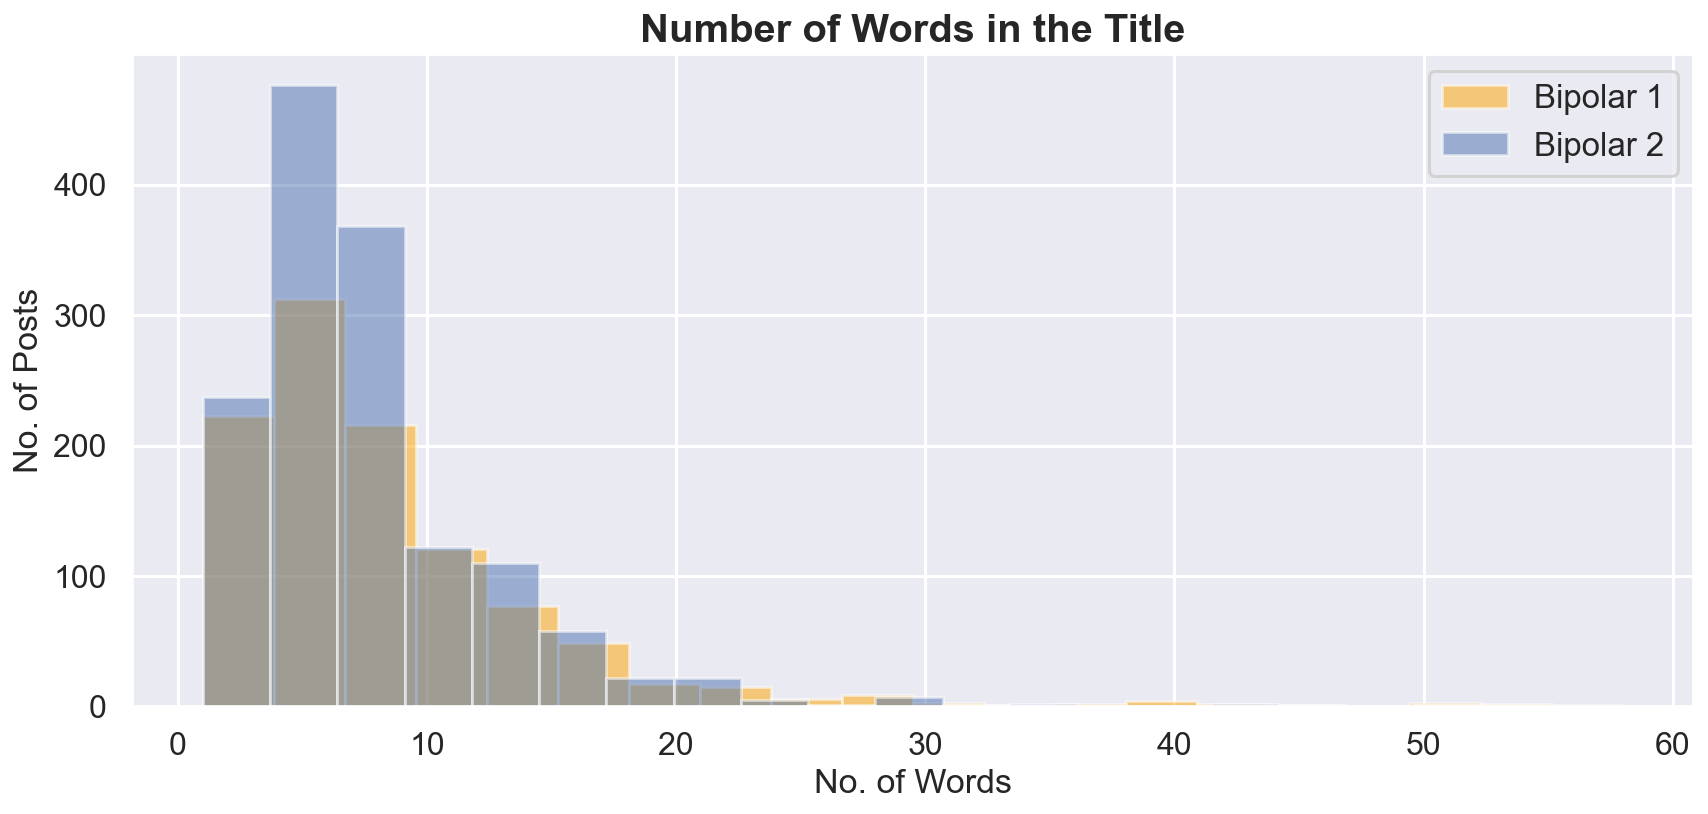

In [36]:
# Specifies the columns to use
bp1_title = bp1['title_num_words']
bp2_title = bp2['title_num_words']

# Plots the histograms with the specified parameters
kwargs = dict(alpha=0.5, bins=20)
plt.hist(bp1_title, **kwargs, color='orange', label='Bipolar 1')
plt.hist(bp2_title, **kwargs, color='b', label='Bipolar 2')

# Sets figure size and various details regarding the title, labels and graph axes
plt.gcf().set_size_inches(14, 6)
plt.tick_params(labelsize=16)
plt.title('Number of Words in the Title', weight='bold', fontsize=20)
plt.xlabel('No. of Words', fontsize=17)
plt.ylabel('No. of Posts', fontsize=17)
plt.legend();

The distributions are very similar. By getting the summary statistics (shown below), we can see that this is indeed the case in terms of all the measures. 

In [37]:
bp1['title_num_words'].describe()

count    1064.000000
mean        8.349624
std         7.037057
min         1.000000
25%         4.000000
50%         6.000000
75%        11.000000
max        58.000000
Name: title_num_words, dtype: float64

In [38]:
bp2['title_num_words'].describe()

count    1436.000000
mean        7.649721
std         5.286813
min         1.000000
25%         4.000000
50%         7.000000
75%         9.000000
max        55.000000
Name: title_num_words, dtype: float64

## Number of words in the `selftext` 

A graph can be plotted to show the distribution. The graph will be truncated at 1000 words.

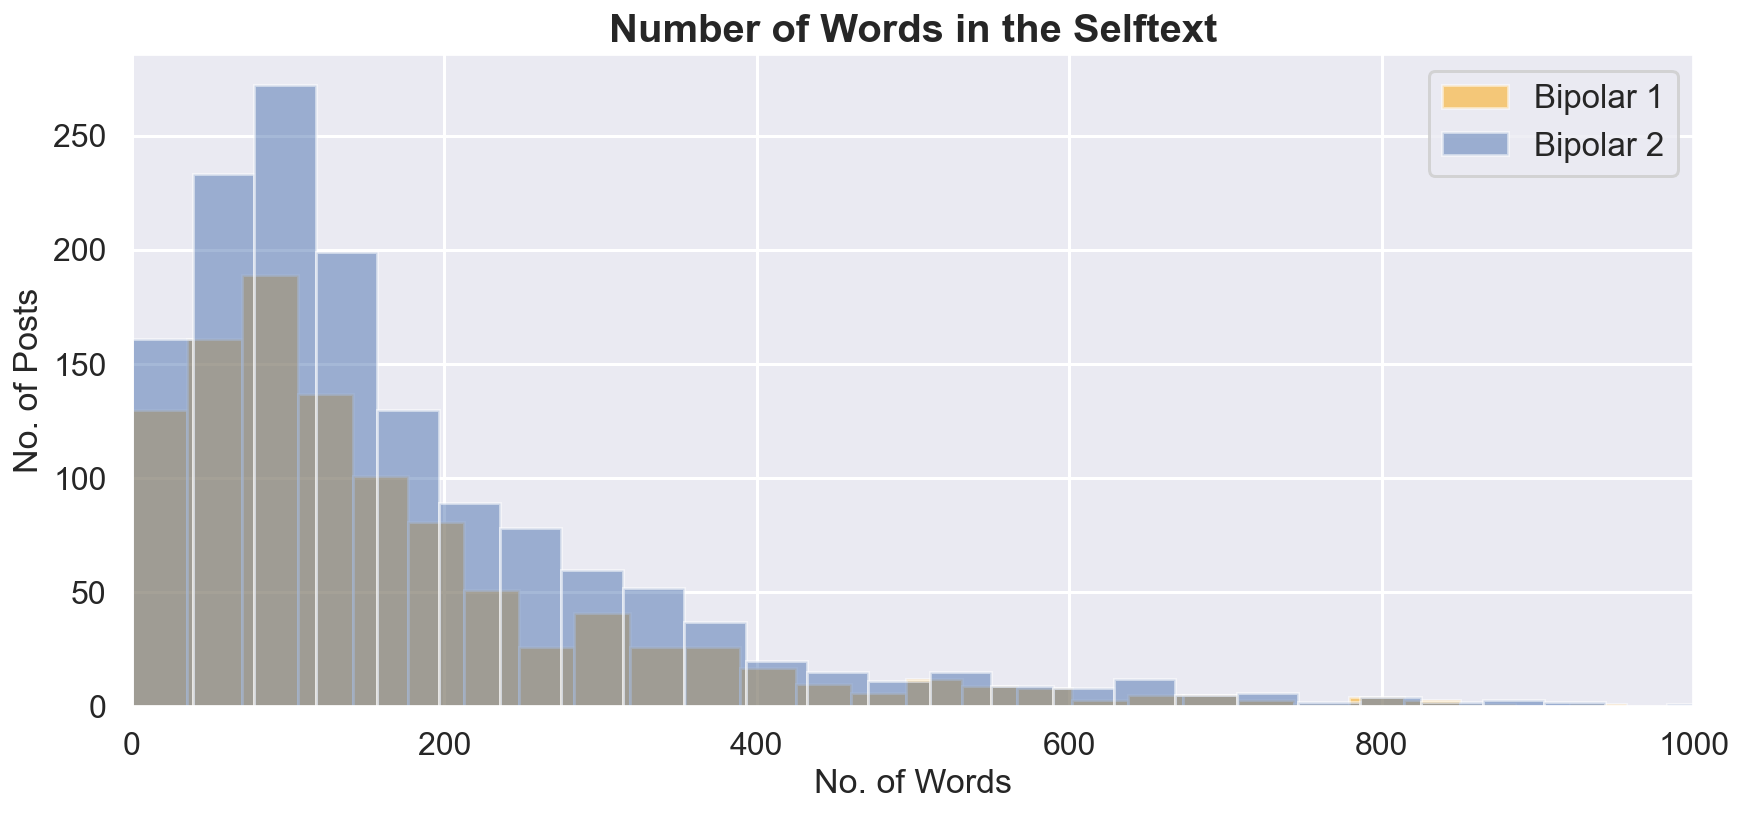

In [39]:
# Specifies the columns to use
bp1_self = bp1['selftext_num_words']
bp2_self = bp2['selftext_num_words']

# Plots the histogram with the specified parameters
kwargs = dict(alpha=0.5, bins=50)
plt.hist(bp1_self, **kwargs, color='orange', label='Bipolar 1')
plt.hist(bp2_self, **kwargs, color='b', label='Bipolar 2')

# Sets figure size and various details regarding the title, labels and graph axes
plt.gcf().set_size_inches(14, 6)
plt.tick_params(labelsize=16)
plt.title('Number of Words in the Selftext', weight='bold', fontsize=20)
plt.xlabel('No. of Words', fontsize=17)
plt.ylabel('No. of Posts', fontsize=17)
plt.legend()

# Restrics the range of the plot
plt.xlim(0,1000);

The distributions are very similar. By getting the summary statistics (shown below), we can see that this is indeed the case in terms of all the measures, but with slightly higher values for Bipolar Type 2.

In [40]:
bp1['selftext_num_words'].describe()

count    1064.000000
mean      172.296053
std       183.540342
min         0.000000
25%        64.000000
50%       119.000000
75%       210.250000
max      1771.000000
Name: selftext_num_words, dtype: float64

In [41]:
bp2['selftext_num_words'].describe()

count    1436.000000
mean      181.424791
std       184.020497
min         0.000000
25%        72.000000
50%       128.000000
75%       233.250000
max      1965.000000
Name: selftext_num_words, dtype: float64

## Number of words in the `text`

This is the combined text of `title` and `selftext`. A graph can be plotted to show the distribution. The graph will be truncated at 1000 words.

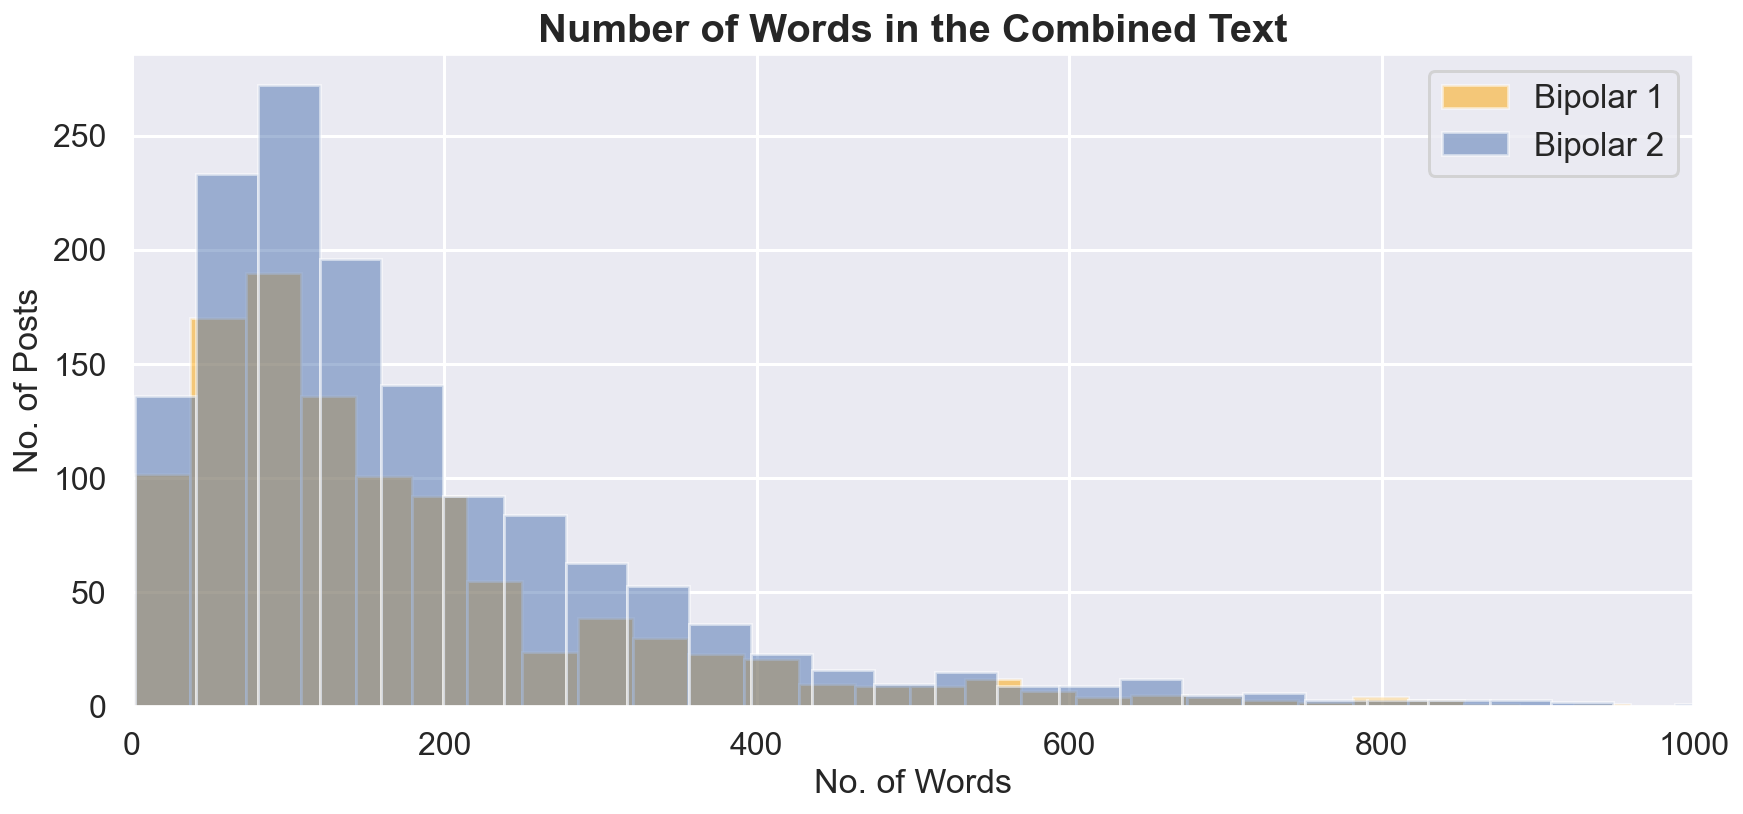

In [42]:
# Specifies the columns to use
bp1_text = bp1['text_num_words']
bp2_text = bp2['text_num_words']

# Plots the histograms with the specified parameters
kwargs = dict(alpha=0.5, bins=50)
plt.hist(bp1_text, **kwargs, color='orange', label='Bipolar 1')
plt.hist(bp2_text, **kwargs, color='b', label='Bipolar 2')

# Sets figure size and various details regarding the title, labels and graph axes
plt.gcf().set_size_inches(14, 6)
plt.tick_params(labelsize=16)
plt.title('Number of Words in the Combined Text', weight='bold', fontsize=20)
plt.xlabel('No. of Words', fontsize=17)
plt.ylabel('No. of Posts', fontsize=17)
plt.legend()

# Restrics the range of the plot
plt.xlim(0,1000);

The distributions are very similar. By getting the summary statistics (shown below), we can see that this is indeed the case in terms of all the measures, but with slightly higher values for Bipolar Type 2.

In [43]:
bp1['text_num_words'].describe()

count    1064.000000
mean      180.645677
std       183.670805
min         2.000000
25%        71.000000
50%       126.500000
75%       219.250000
max      1774.000000
Name: text_num_words, dtype: float64

In [44]:
bp2['text_num_words'].describe()

count    1436.000000
mean      189.074513
std       184.503264
min         2.000000
25%        78.000000
50%       135.000000
75%       241.250000
max      1973.000000
Name: text_num_words, dtype: float64

## Submission frequencies

We will begin to study the compound scores with respect to different time frames. First, we will check out the submission frequency by year.

### Submission frequency by year

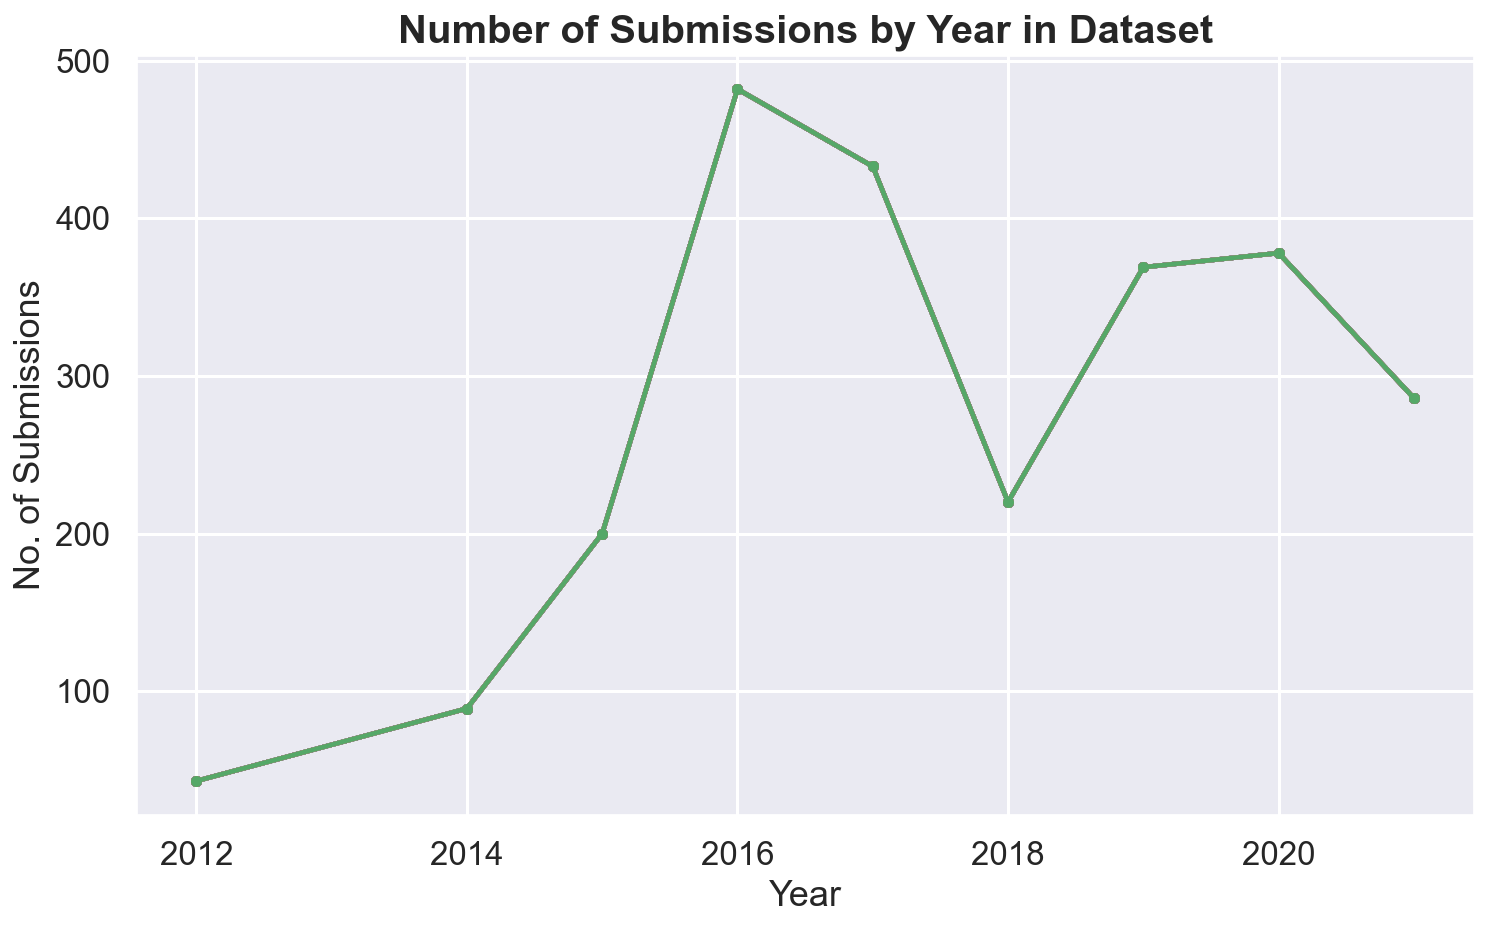

In [45]:
plt.plot(sb.groupby([sb['year_']]).count(), marker='.')
fig = plt.gcf()
fig.set_size_inches(12, 7)
plt.xlabel('Year')
plt.ylabel('No. of Submissions')
plt.title('Number of Submissions by Year in Dataset', weight='bold', fontsize=20);

It seems that there were very little submissions related to the three mood stabilisers before 2014, and none in 2013. There was also a dip in the 2018 data. For these portions, there was data, but authors did not identify themselves as either Bipolar 1 or 2 in their flairs.

### Submission frequency by month

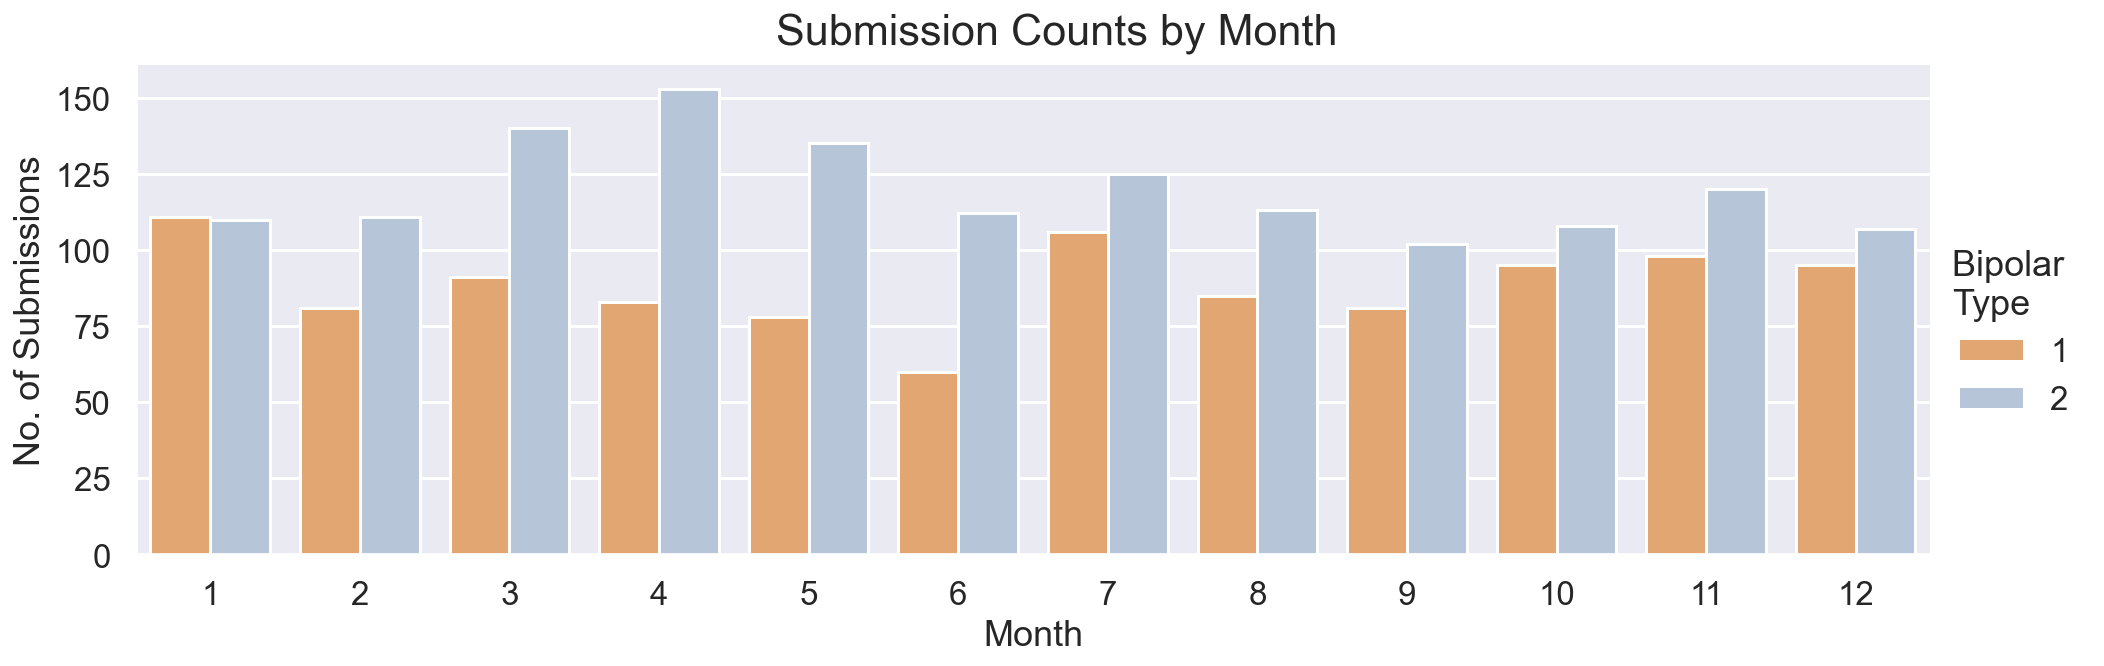

In [46]:
g = sns.catplot(x='month_', 
                kind='count', 
                hue='bp_type', 
                data=sb,
                height=4.5, 
                aspect=3, 
                palette={1: 'sandybrown', 2:'lightsteelblue'})

# This adjustment adds padding under the title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Submission Counts by Month')
g.set_ylabels('No. of Submissions')
g.set_xlabels('Month')
g._legend.set_title('Bipolar \nType');

Submission counts show a clear peak in April for Bipolar 2, and show a clear dip in June for Bipolar 1. April is when suicide rates peak, and perhaps that might be related to the peak ([*source*](https://www.emedicinehealth.com/what_is_the_most_suicidal_month/article_em.htm)).

### Submission frequency by day of week

For this part, we will create another column that indicates the day of the week in words. 

In [47]:
sb['weekday_'] = sb['day_of_week_'].replace(to_replace=0, value='Mon', regex=False)
sb['weekday_'] = sb['weekday_'].replace(to_replace=1, value='Tue', regex=False)
sb['weekday_'] = sb['weekday_'].replace(to_replace=2, value='Wed', regex=False)
sb['weekday_'] = sb['weekday_'].replace(to_replace=3, value='Thu', regex=False)
sb['weekday_'] = sb['weekday_'].replace(to_replace=4, value='Fri', regex=False)
sb['weekday_'] = sb['weekday_'].replace(to_replace=5, value='Sat', regex=False)
sb['weekday_'] = sb['weekday_'].replace(to_replace=6, value='Sun', regex=False)

The values are indicated in the new column:

In [48]:
sb['weekday_'].value_counts()

Tue    407
Thu    394
Wed    378
Fri    366
Sun    341
Mon    335
Sat    279
Name: weekday_, dtype: int64

The plot is as follows:

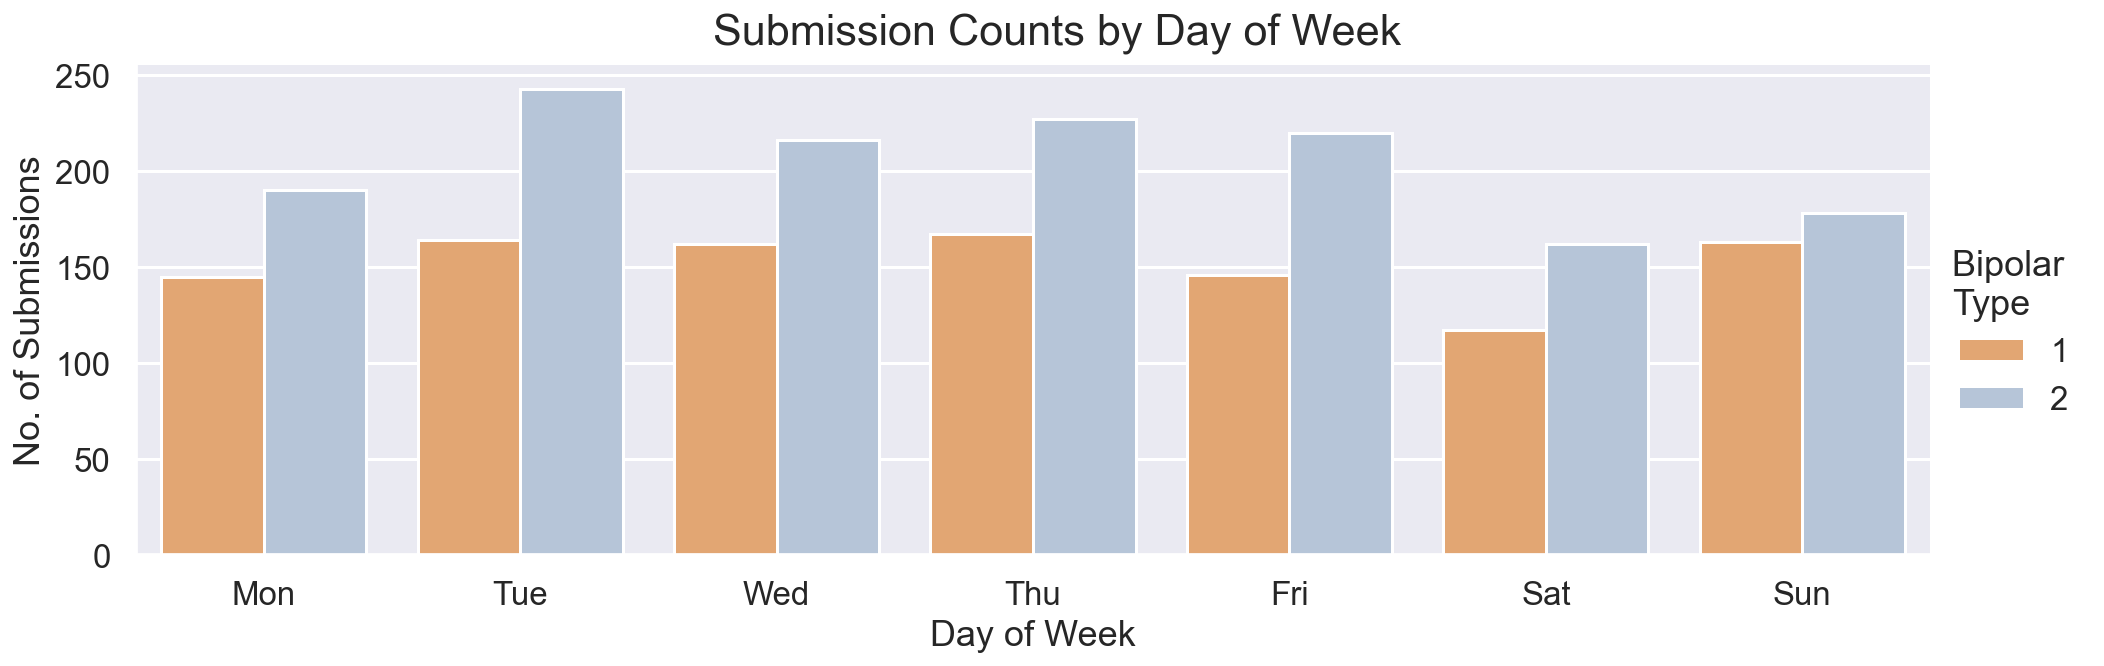

In [49]:
g = sns.catplot(x='weekday_', 
                kind='count', 
                hue='bp_type', 
                data=sb, 
                order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                height=4.5, 
                aspect=3, 
                palette={1: 'sandybrown', 2:'lightsteelblue'})

# This adjustment adds padding under the title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Submission Counts by Day of Week')
g.set_ylabels('No. of Submissions')
g.set_xlabels('Day of Week')
g._legend.set_title('Bipolar \nType');

Submission counts dip on Saturdays in general.

### Submission frequency by hour

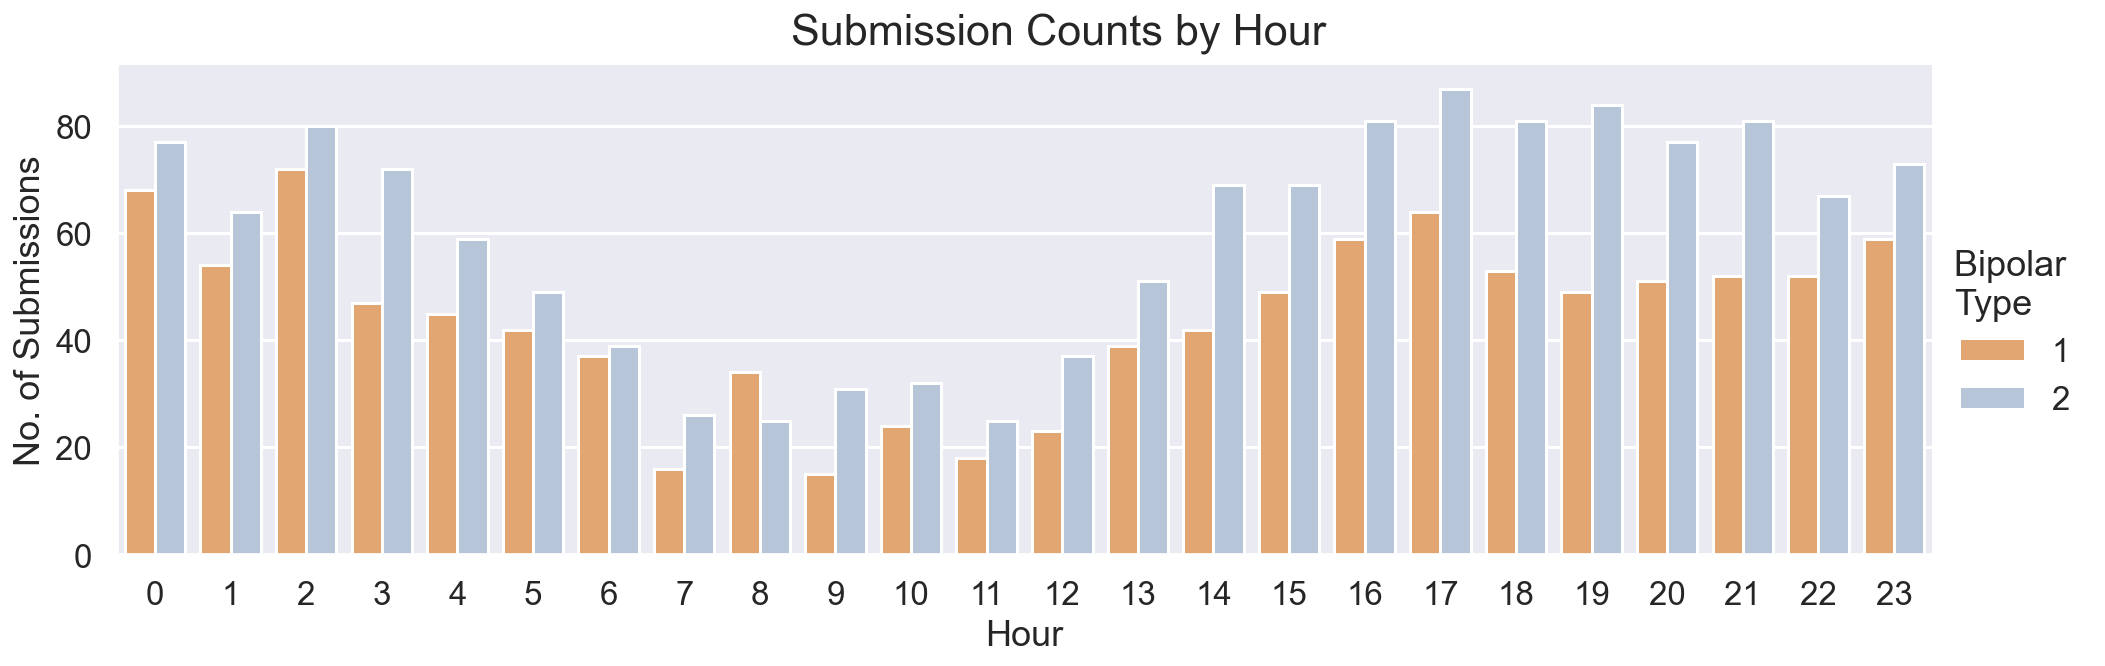

In [50]:
g = sns.catplot(x='hour_', 
                kind='count', 
                hue='bp_type', 
                data=sb,
                height=4.5, 
                aspect=3, 
                palette={1: 'sandybrown', 2:'lightsteelblue'})

# This adjustment adds padding under the title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Submission Counts by Hour')
g.set_ylabels('No. of Submissions')
g.set_xlabels('Hour')
g._legend.set_title('Bipolar \nType');

UTC 7AM is 2AM in Washington, DC, USA, which fits the observation that around half of Reddit users come from the United States. The dip corresponds to the general sleeping time of humans. Although bipolar disorder has some circadian rhythm disturbances, users may be posting on Reddit while they are in a more stable state.

# Sentiment Analysis

We will use the compound score for our analysis. According to the VADER documentation ([*source*](https://github.com/cjhutto/vaderSentiment)):

>The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

>* positive sentiment: compound score >= 0.05
>* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
>* negative sentiment: compound score <= -0.05

We will first obtain some summary statistics.

In [51]:
bp1[['neg', 'neu', 'pos', 'compound_']].describe()

,neg,neu,pos,compound_
count,1064.000000,1064.000000,1064.000000,1064.000000
mean,0.104079,0.797544,0.098377,-0.099351
std,0.068773,0.094792,0.074757,0.738979
min,0.000000,0.239000,0.000000,-0.999200
25%,0.055000,0.745000,0.055000,-0.859875
50%,0.098000,0.800000,0.091000,-0.226000
75%,0.145000,0.855000,0.129250,0.689350
max,0.480000,1.000000,0.761000,0.998500


In [52]:
bp2[['neg', 'neu', 'pos', 'compound_']].describe()

,neg,neu,pos,compound_
count,1436.000000,1436.000000,1436.000000,1436.000000
mean,0.114633,0.787838,0.097515,-0.147010
std,0.071047,0.087555,0.062875,0.755552
min,0.000000,0.396000,0.000000,-0.999100
25%,0.066000,0.736000,0.055000,-0.902200
50%,0.110000,0.785500,0.092000,-0.376000
75%,0.157250,0.842000,0.134000,0.677750
max,0.561000,1.000000,0.604000,0.999300


The compound score will be used. We will plot an overview of the compound scores by bipolar type and indicate the median.

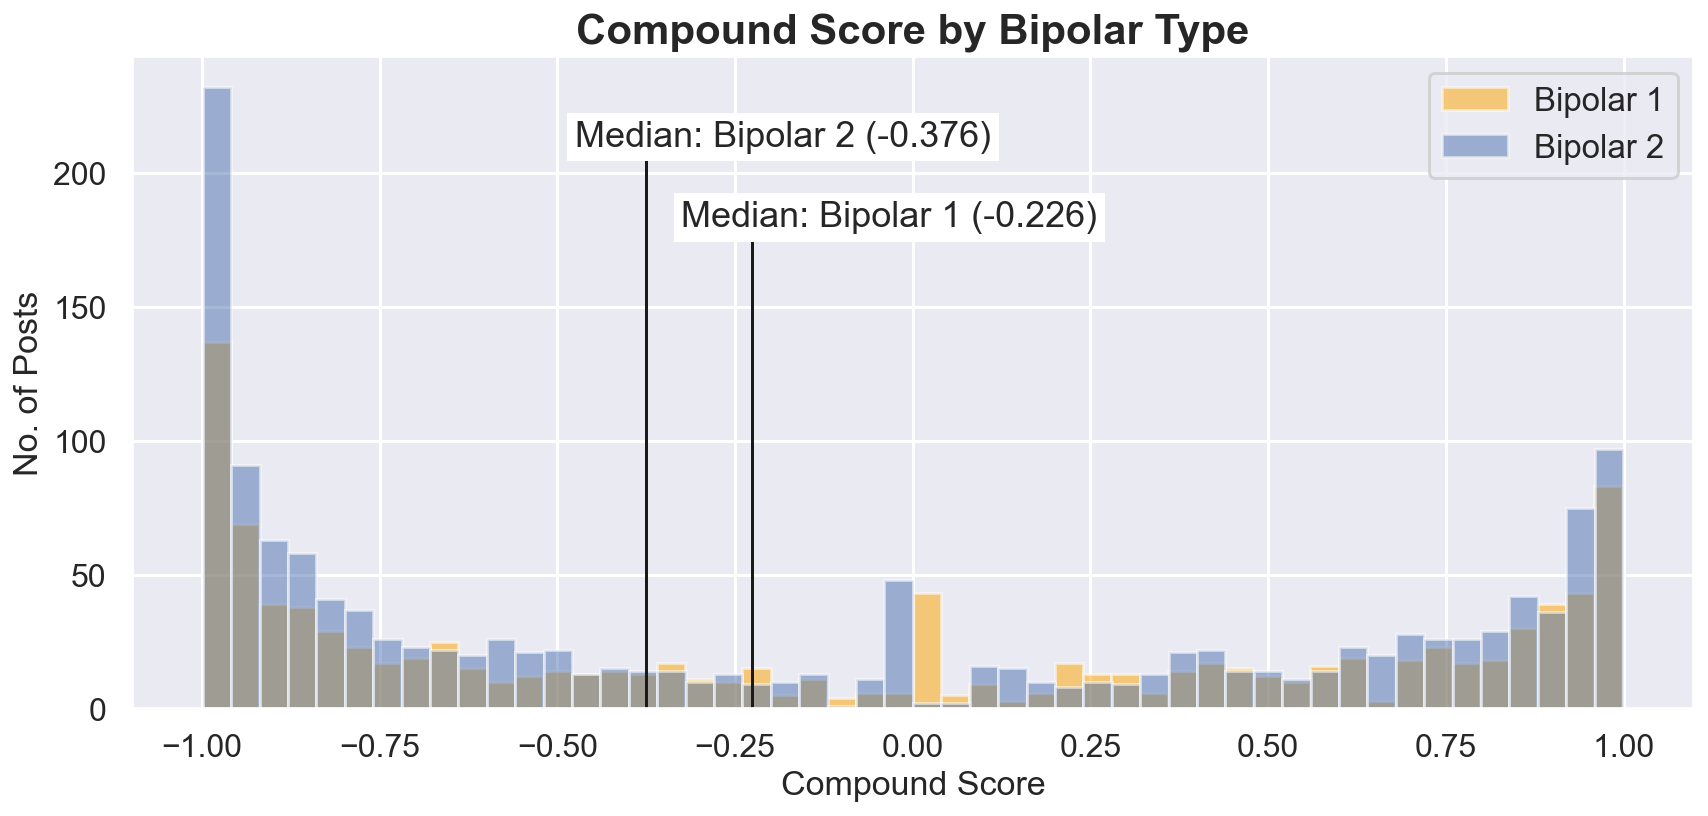

In [53]:
# Specifies the columns to use
bp1_comp = bp1['compound_']
bp2_comp = bp2['compound_']

# Plots the histograms with the specified parameters
kwargs = dict(alpha=0.5, bins=50)
plt.hist(bp1_comp, **kwargs, color='orange', label='Bipolar 1')
plt.hist(bp2_comp, **kwargs, color='b', label='Bipolar 2')

# Plots an indic
plt.vlines(bp1_comp.median(), ymin=0, ymax=180, color="k", linestyle="solid", linewidth=1.5)
plt.text(bp1_comp.median()-0.1, 180, "Median: Bipolar 1 ({})".format(bp1_comp.median()), bbox={'facecolor': 'white', 'pad': 3})

plt.vlines(bp2_comp.median(), ymin=0, ymax=210, color="k", linestyle="solid", linewidth=1.5)
plt.text(bp2_comp.median()-0.1, 210, "Median: Bipolar 2 ({})".format(bp2_comp.median()), bbox={'facecolor': 'white', 'pad': 3})

# Sets figure size and various details regarding the title, labels and graph axes
plt.gcf().set_size_inches(14, 6)
plt.tick_params(labelsize=16)
plt.title('Compound Score by Bipolar Type', weight='bold', fontsize=21)
plt.xlabel('Compound Score', fontsize=17)
plt.ylabel('No. of Posts', fontsize=17)
plt.legend();

Here, we can clearly see a larger number of posts having the lowest possible compound score by Bipolar 2 authors. This reflects the higher tendency for depressive episodes in Type 2.

### Compound Score by Year

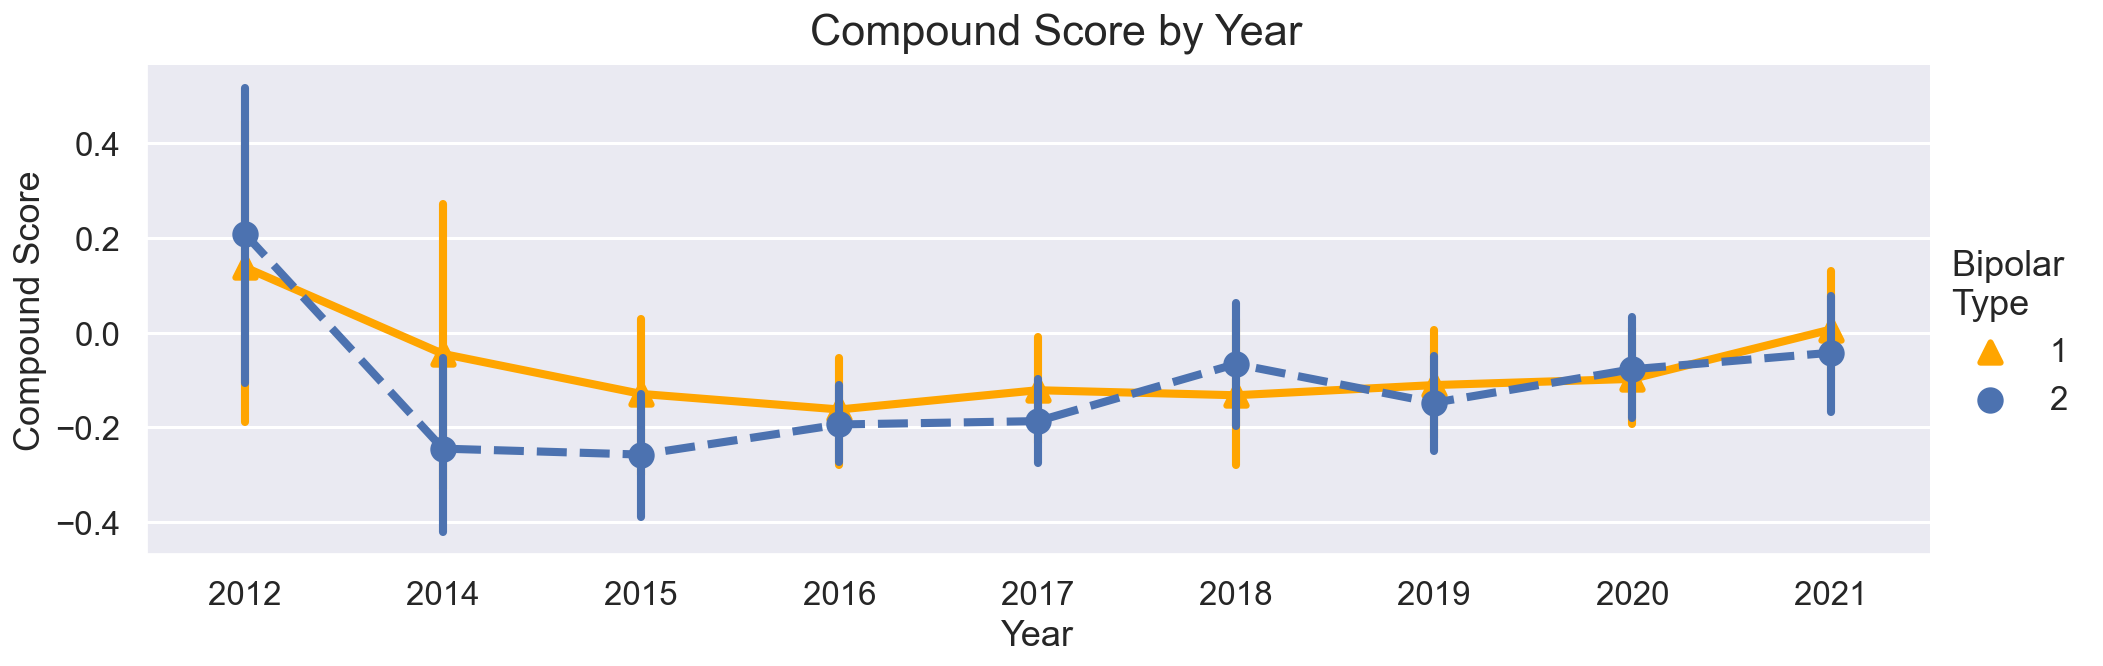

In [54]:
g = sns.catplot(x='year_', 
            y='compound_', 
            kind='point', 
            hue='bp_type', 
            data=sb,
            height=4.5, 
            aspect=3, 
            palette={1: 'orange', 2:'b'}, 
            markers=['^', 'o'], 
            linestyles=['-', '--'])

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Compound Score by Year')
g.set_ylabels('Compound Score')
g.set_xlabels('Year')
g._legend.set_title('Bipolar \nType');

It seems that the graph shows a large difference between bipolar subtypes before 2016, and also the compound score for Bipolar 2 becomes higher than that of bipolar 1 in 2018. However, these correspond to the years where the counts are anomalous as shown in the figure titled, 'Number of Submissions by Year in Dataset'. Excluding these portions, we can see that the compound scores for Type 1 are similar or very slightly higher than that for Type 2, which reflects the higher tendency for depressive episodes in Type 2. 

### Compound Score by Month

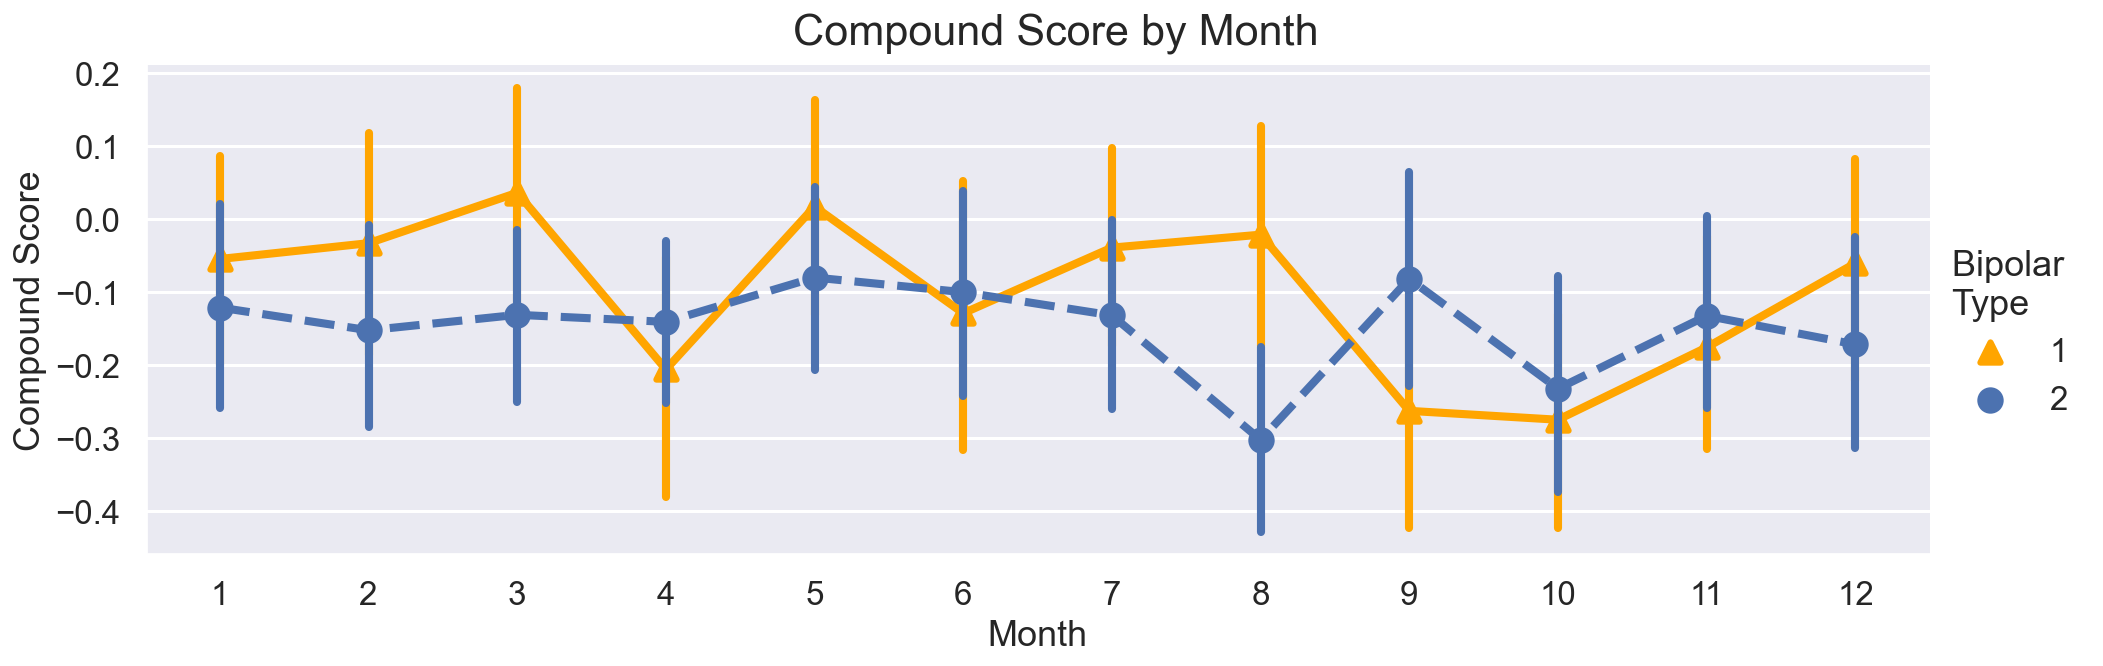

In [55]:
g = sns.catplot(x='month_', 
                y='compound_', 
                kind='point', 
                hue='bp_type', 
                data=sb,
                height=4.5, 
                aspect=3, 
                palette={1: 'orange', 2:'b'}, 
                markers=['^', 'o'], 
                linestyles=['-', '--'])

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Compound Score by Month')
g.set_ylabels('Compound Score')
g.set_xlabels('Month')
g._legend.set_title('Bipolar \nType');

Here, we can see that Bipolar 1 compound scores are generally higher than Bipolar 2 compound scores. However, the line for Bipolar 1 dips below that of Bipolar 2 in April as well as for September, October and November. 

It seems that there is an increase in manic behaviour in the springtime (April onwards) and this sparks manic self-destructive behaviours and increased suicide rates ([*source*](https://www.mghclaycenter.org/parenting-concerns/teenagers/spring-suicide-an-unlikely-combination/)) ([*source*](https://www.emedicinehealth.com/what_is_the_most_suicidal_month/article_em.htm)). The most plausible reason is due to inducement of mixed states from shifting circadian rhythms, and this can be destructive and trigger suicide due to the emotional instability ([*source*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5900367/)). As mentioned in the Background and Research, mixed states carry a serious risk of suicide. In fact, there are peaks in suicide for April and August, which corresponds to the two major dips in the graph ([*source*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3315262/)). Reasons for the August peak also were linked to changing sunshine hours as well ([*source*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3315262/)) ([*source*](https://pubmed.ncbi.nlm.nih.gov/17199100/)).

### Compound Score by Day of Week

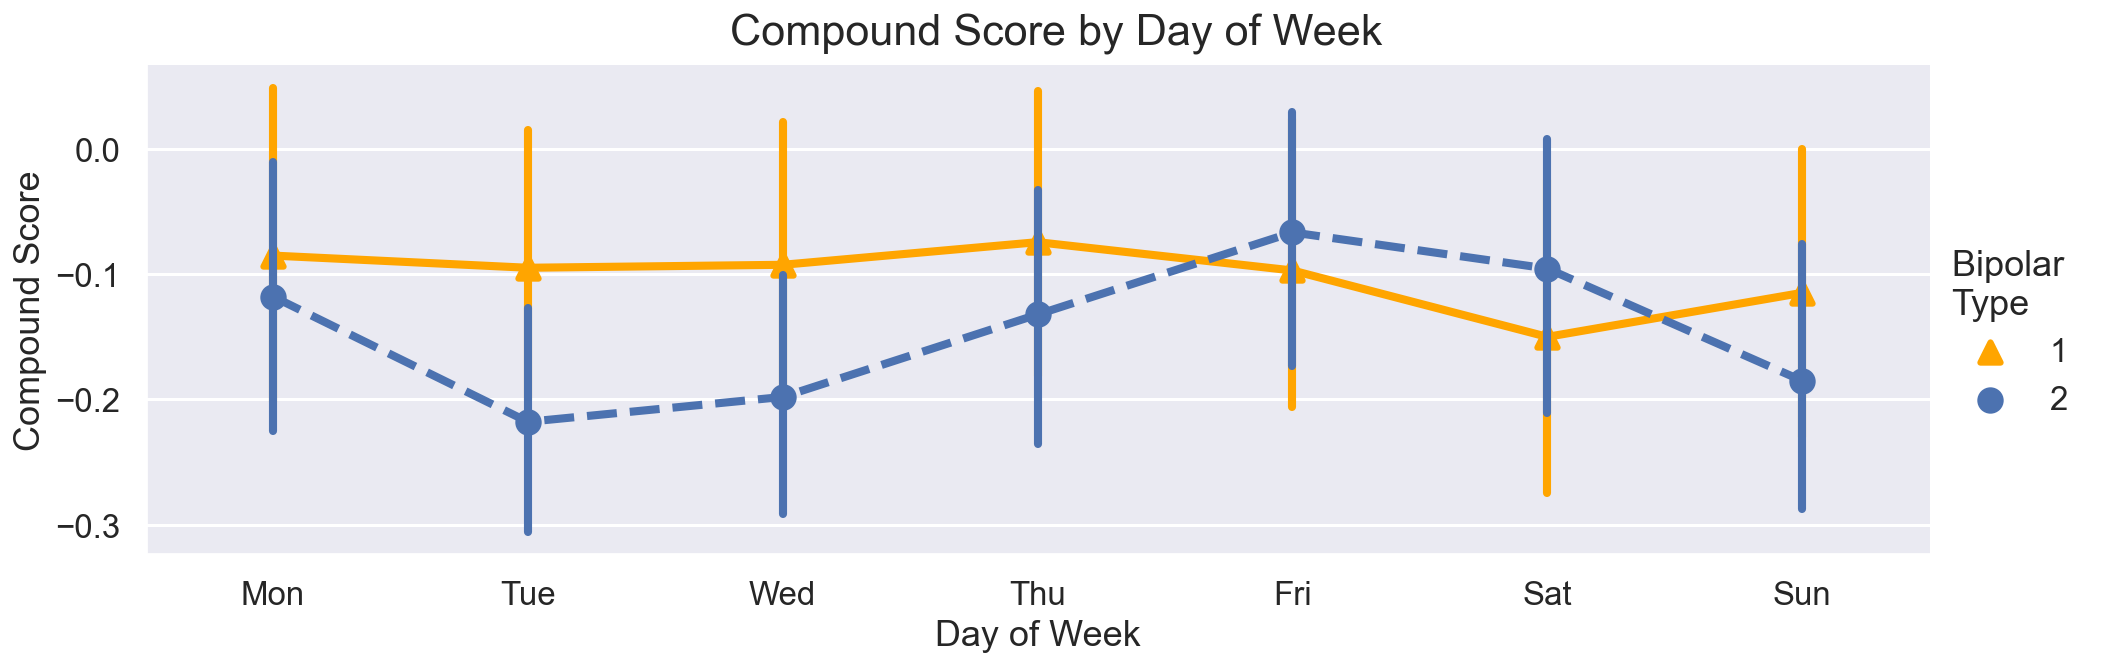

In [56]:
g = sns.catplot(x='weekday_', 
            y='compound_', 
            kind='point', 
            hue='bp_type', 
            data=sb, 
            order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            height=4.5, 
            aspect=3, 
            palette={1: 'orange', 2:'b'}, 
            markers=['^', 'o'], 
            linestyles=['-', '--'])

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Compound Score by Day of Week')
g.set_ylabels('Compound Score')
g.set_xlabels('Day of Week')
g._legend.set_title('Bipolar \nType');

In this case, it seems that the curve for Bipolar 2 dips below that of Bipolar 1 quite drastically, peaks on Friday and then drops. The weekend might provide a mood-booster for the predominantly-depressed Type 2 individuals. 

## Percentage of serious topics 

Previously, we created an indicator for when a post belonged to a serious topic. We can now plot this out. 

### Percentage of serious topics by year 

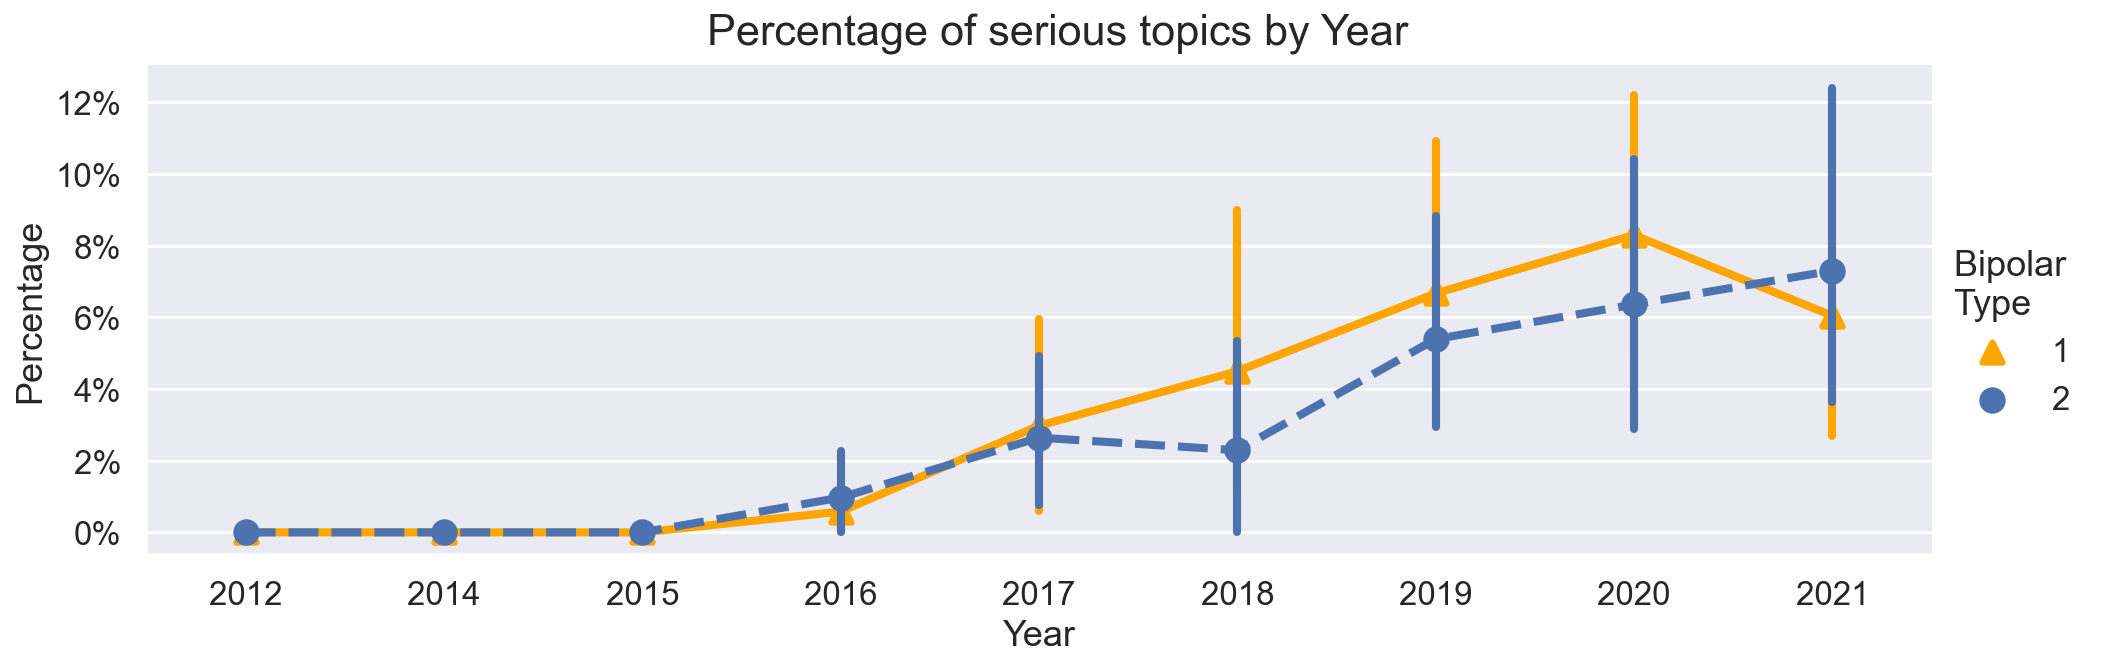

In [57]:
g=sns.catplot(x='year_', 
              y='serious_', 
              kind='point', 
              hue='bp_type', 
              data=sb, 
              height=4.5, 
              aspect=3, 
              palette={1: 'orange', 2:'b'}, 
              markers=['^', 'o'], 
              linestyles=['-', '--'])

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percentage of serious topics by Year')
g.set_ylabels('Percentage')
g.set_xlabels('Year')
g._legend.set_title('Bipolar \nType');

Here, we can see that more posts by Bipolar 1 authors generally fall into the serious category.

### Percentage of serious topics by month 

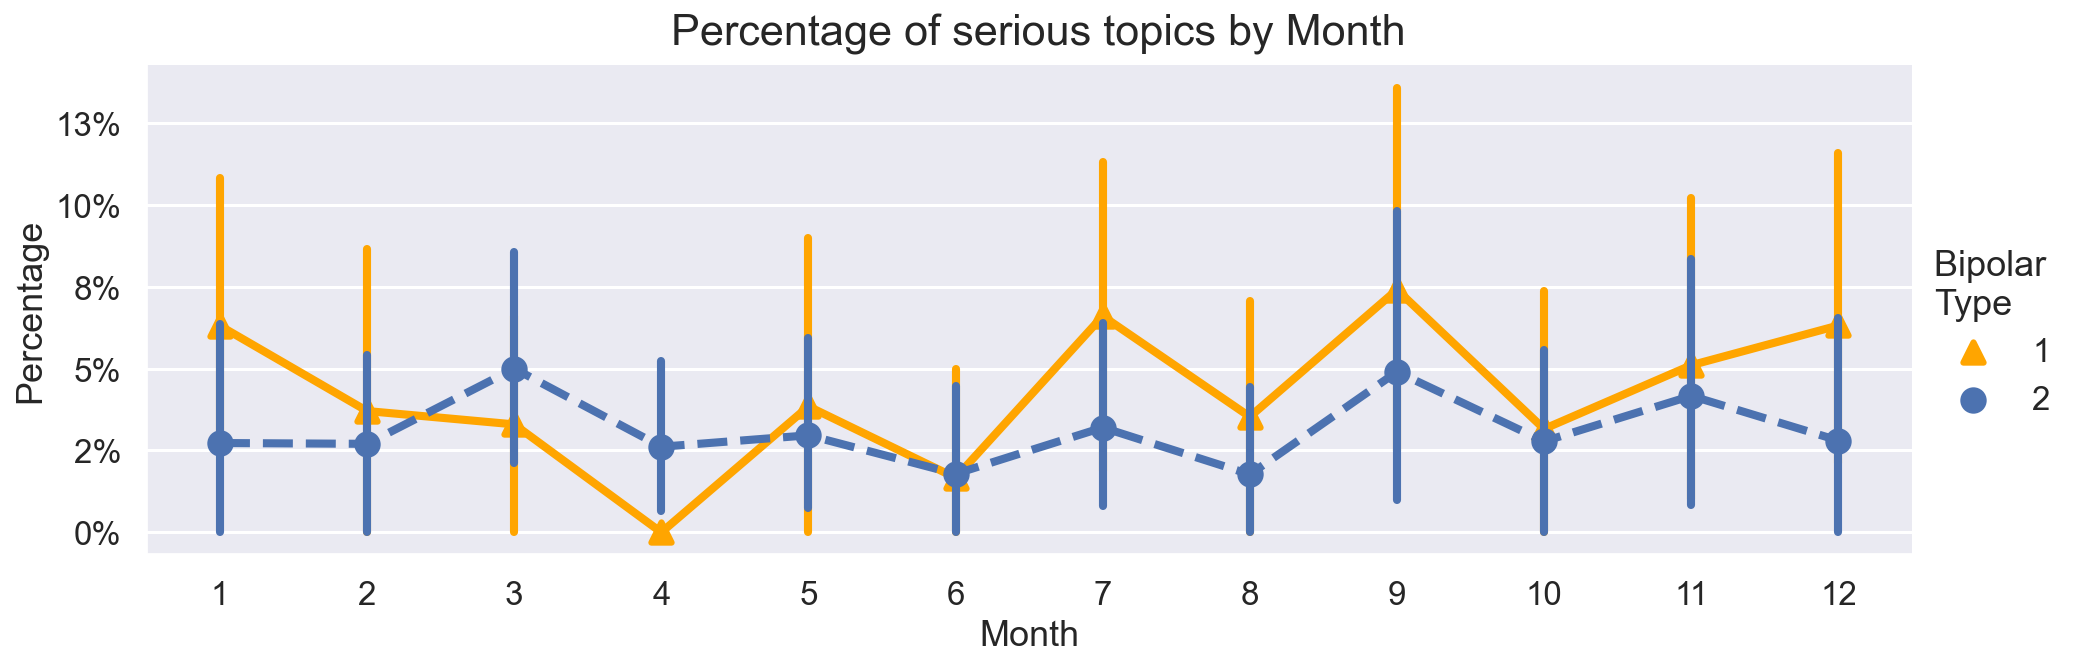

In [58]:
g=sns.catplot(x='month_', 
              y='serious_', 
              kind='point', 
              hue='bp_type', 
              data=sb, 
              height=4.5, 
              aspect=3, 
              palette={1: 'orange', 2:'b'}, 
              markers=['^', 'o'], 
              linestyles=['-', '--'])

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percentage of serious topics by Month')
g.set_ylabels('Percentage')
g.set_xlabels('Month')
g._legend.set_title('Bipolar \nType');

We see that there are more posts by Bipolar 1 authors in the serious category, save for a distinct dip in April. Interestingly, this ties in with the April dip in compound scores for Bipolar 1 authors. This would mean that in April, Bipolar 1 authors did not post on serious topics, but yet their sentiment in posts they wrote was detected as more negative than what it usually would have been (to the extent that it showed up as an unusual dip). Considering the discussion on that matter, this could be taken as a cause for concern. This is because it might indicate that the authors did not think there was anything serious to discuss, but were undergoing mood instability in actual fact.

### Percentage of serious topics by day of week

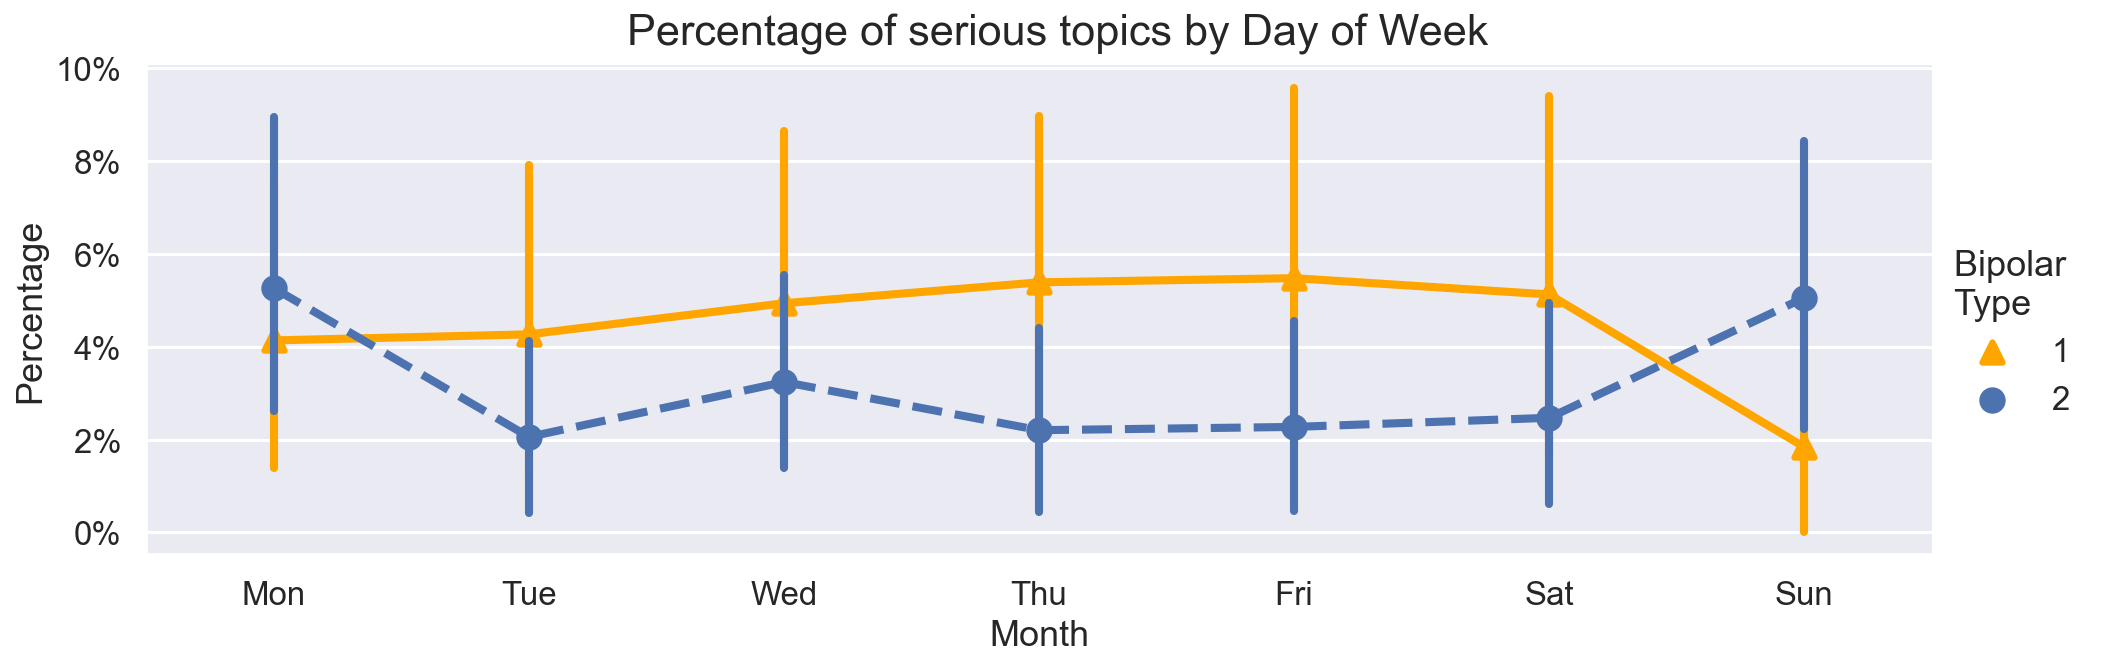

In [59]:
g=sns.catplot(x='weekday_', 
              y='serious_', 
              kind='point', 
              hue='bp_type', 
              data=sb, 
              order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
              height=4.5, 
              aspect=3, 
              palette={1: 'orange', 2:'b'}, 
              markers=['^', 'o'], 
              linestyles=['-', '--'])

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percentage of serious topics by Day of Week')
g.set_ylabels('Percentage')
g.set_xlabels('Month')
g._legend.set_title('Bipolar \nType');

In this case, we see that the serious topics peak on Sundays and Mondays for Type 2. This actually relates to what was seen in the compound score by day of week. It might indicate that Bipolar 2 patients are very sensitive to fluctuations of mood brought on by the weekend.

# Natural Language Processing 

Natural Language Processing techniques can be applied on the data, which involves first cleaning the data, then identifying the most common words in the dataset and finally, topic modelling.

### Text cleaning

The data contains punctuation symbols, emojis and possibly non-English characters. We will remove these. After removal, there could be empty strings, so these will be also be removed to clean up the data.

We will perform tokenisation for the text in each post to split them up into a list of words. For these words, lemmatisation will be done to convert the inflected forms of words into their base form and thus simplify the list of words. The words will also all be converted to lowercase as there is a distinction when words are in different cases. Stopwords will also be removed. These stopwords are words that frequently occur in all text, and thus they are removed to reduce unnecessary noise in the model. Extra stopwords were specified, as many of the posts were related to people asking questions and describing how they felt.

The function below does the cleaning, and the extra stopwords specified are also shown below.

In [60]:
stopwords = nltk.corpus.stopwords.words('english')

stopword_list = ['feel', 'like', 'take', 'taking', 'go', 'get', 'bipolar', 'day', 'month', 'year', 
                 'med', 'meds', 'know', 'anyone', 'want', 'else', 'also']

stopwords.extend(stopword_list)

wn = nltk.WordNetLemmatizer()

def clean_text(text):

    # Tokenisation and punctuation removal. \W matches any non-word character (equivalent to [^a-zA-Z0-9_]).
    # Since \W does not match underscores, we specify '\W+|_' (\W or underscore).
    # Splits the text at any of these non-word characters (or groups of them). 
    # The '+' is to handle cases where there are 2 or more non-word characters between certain words
    tokens = re.split(r'\W+|_', text)
 
    # Removes all words that contain non-ASCII printable characters
    ascii_chars = set(string.printable)
    tokens =  [word for word in tokens if all(char in ascii_chars for char in word)]
    
    # Removes all empty strings, e.g. ''
    tokens = [word for word in tokens if word]
   
    # Apply lemmatisation, lowercasing and stopwords exclusion within the same step.
    tokens = [wn.lemmatize(word.lower()) for word in tokens if word.lower() not in stopwords] 
     
    return tokens

## Word Vectorisation

We can analyse each post as a bag of words. 

The `CountVectorizer` can convert the words into a matrix where each row is a post, and each column represents a word in the post. The value in each cell simply represents the number of occurences of that word in that post. The column names used represent all the unique words that we are tracking in the dataset.

The `TfidfVectorizer` can convert the words into a matrix where each row is a post, and each column represents a word in the post. However, instead of the value in each cell simply representing the number of occurences of that word in that post, this number is actually multiplied by its inverse document frequency. This is the TFIDF, or term frequency–inverse document frequency. This weighting means that words that appear less in the data will have a higher TFIDF value, thus preventing common words from drowning out the significance of rarer ones which may also be predictive. As with the `CountVectorizer`, the column names used represent all the unique words that we are tracking in the dataset. 

We will create a function that takes the desired vectoriser as an argument and then plots the bar graphs of the top word counts. 

In [61]:
def word_chart(vectorizer, column, title):    

    # X_counts stores the vectorized version of the data
    X_counts = vectorizer.fit_transform(column)

    # Creates a DataFrame of the word counts
    X_counts_df = pd.DataFrame(X_counts.toarray(), columns=vectorizer.get_feature_names())

    # Takes the top 25 words based on counts and stores them in a DataFrame
    X_counts_sum = X_counts_df.sum().sort_values(ascending=False).head(25)

    # Plots the top 25 words based on counts
    X_counts_sum.sort_values(ascending=True).plot(kind='barh', figsize=(8,10), legend=False)
    plt.title(title);

### Single words

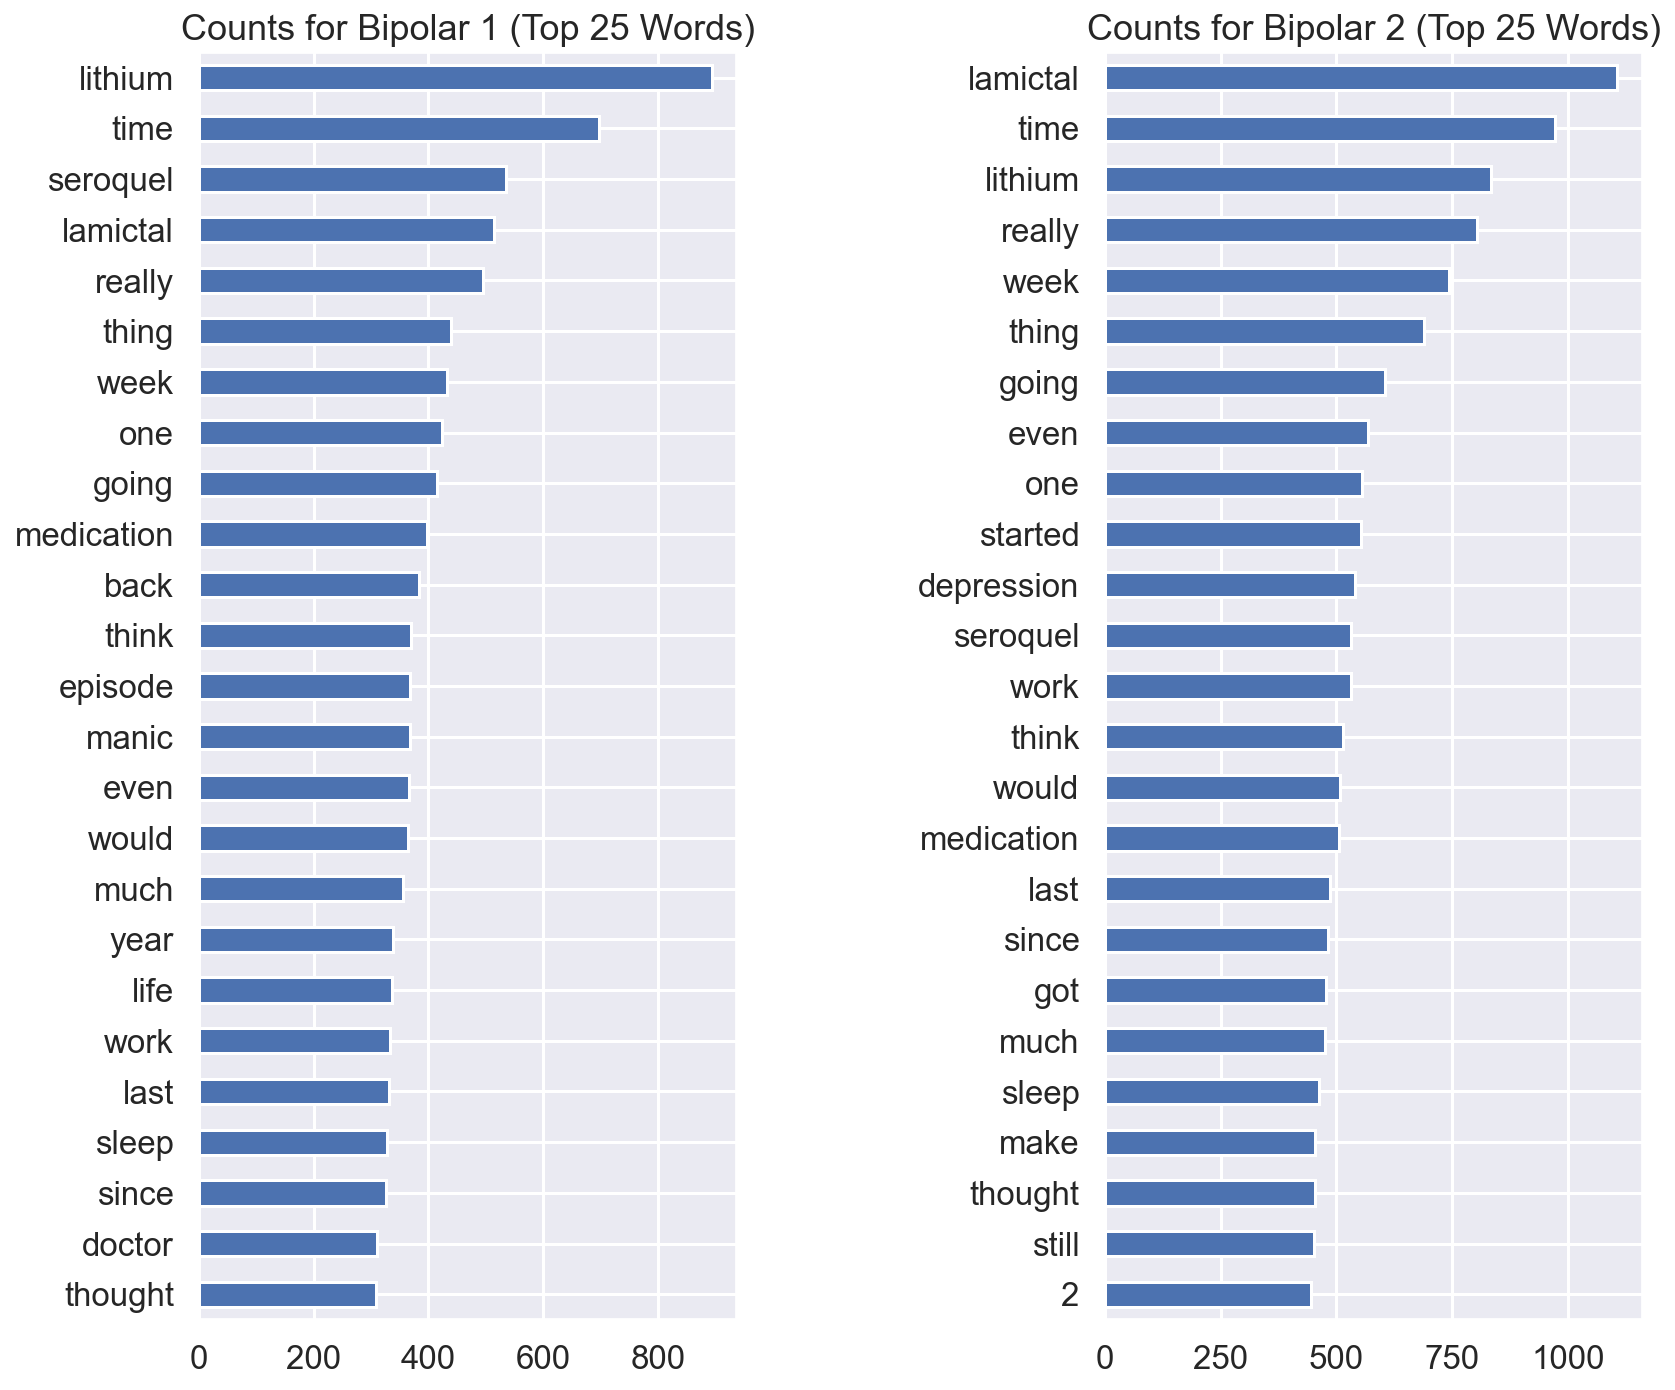

In [62]:
# Create an instance of CountVectorizer and pass in the clean_text function as the analyzer parameter
count_vect = CountVectorizer(analyzer=clean_text, max_features=100)

fig, axs = plt.subplots(nrows=1, ncols=2)
plt.subplot(1, 2, 1)
word_chart(count_vect, bp1['text'], 'Counts for Bipolar 1 (Top 25 Words)')
plt.subplot(1, 2, 2)
word_chart(count_vect, bp2['text'], 'Counts for Bipolar 2 (Top 25 Words)')
fig.tight_layout()
fig.set_size_inches(13, 10)

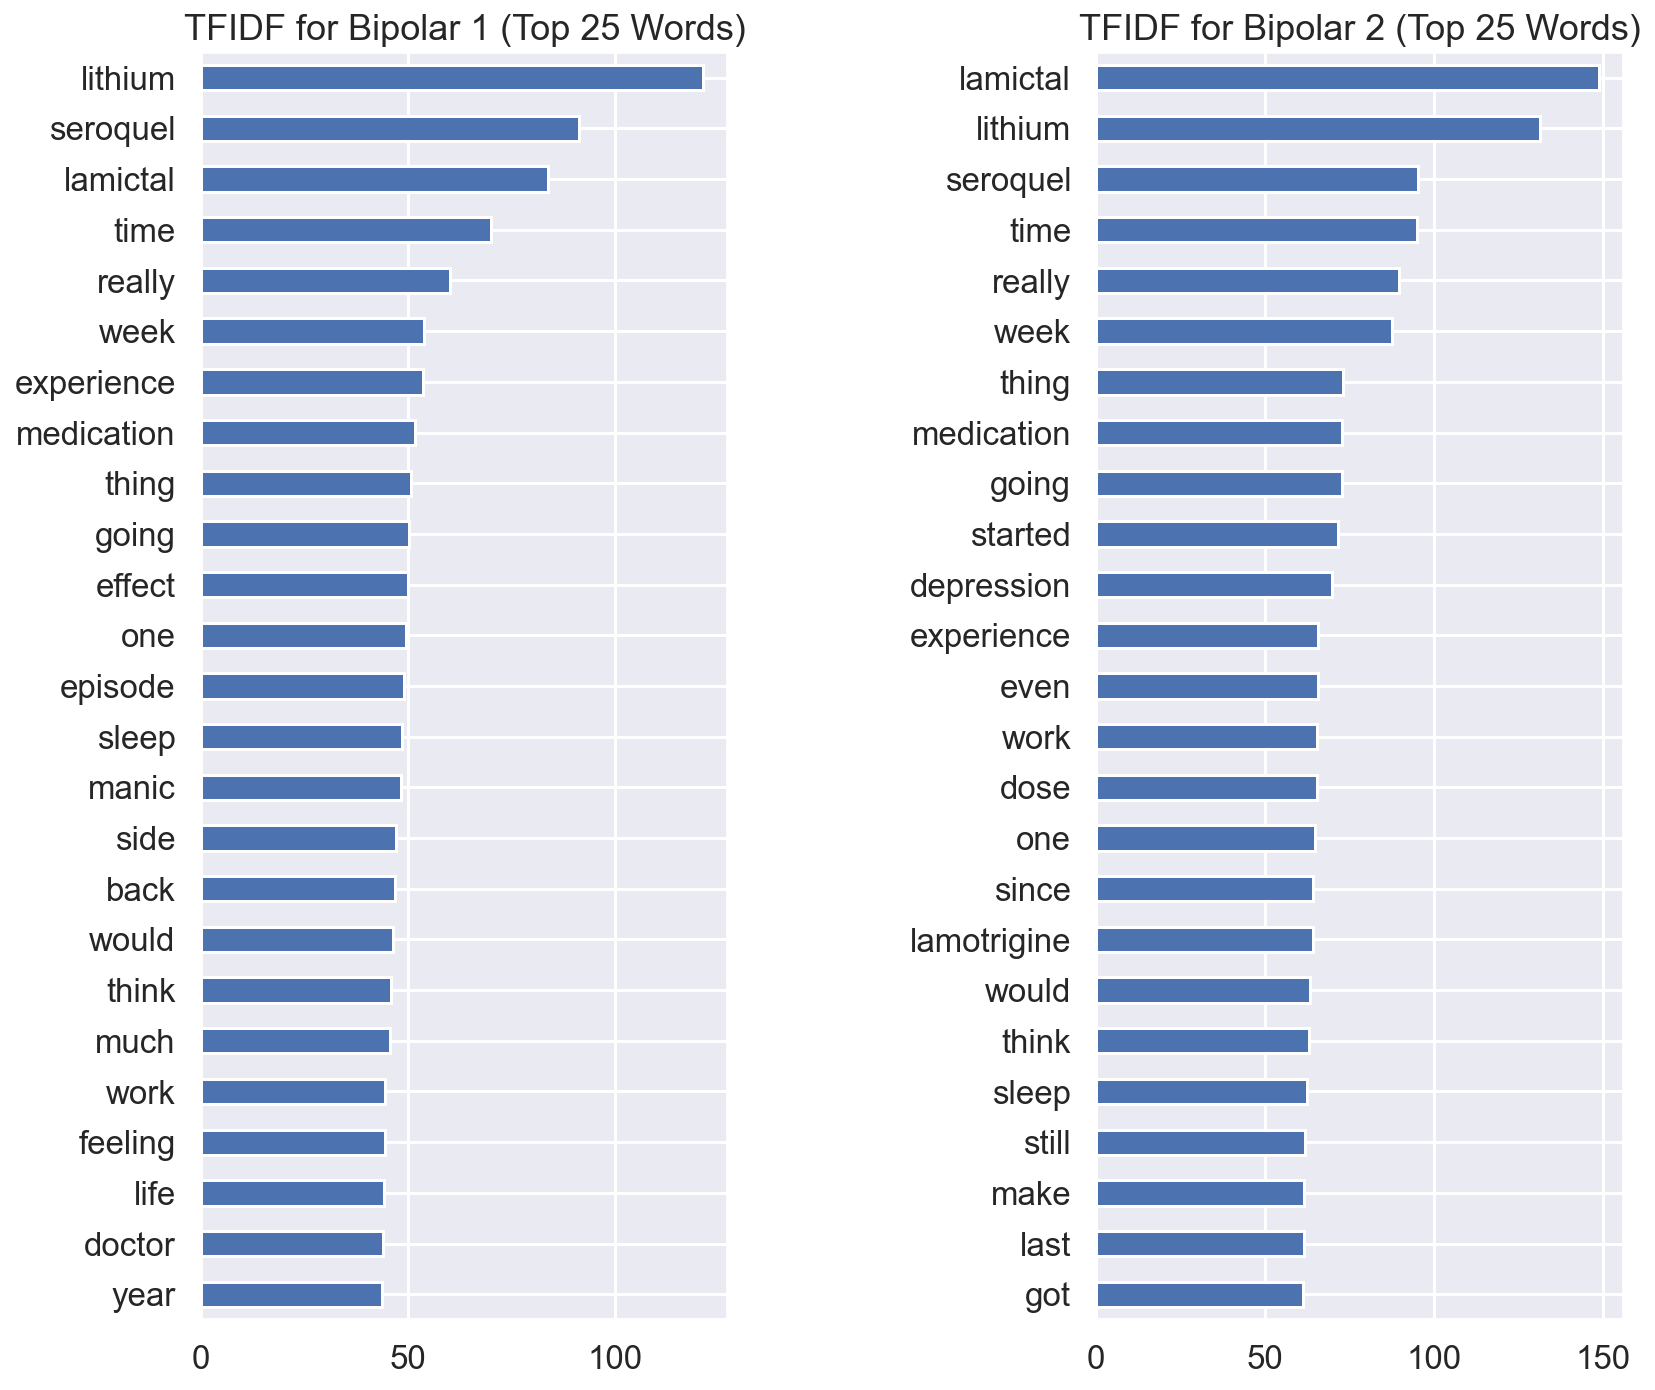

In [63]:
# Create an instance of TfidfVectorizer and pass in the clean_text function as the analyzer parameter
tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=100)

fig, axs = plt.subplots(nrows=1, ncols=2)
plt.subplot(1, 2, 1)
word_chart(tfidf_vect, bp1['text'], 'TFIDF for Bipolar 1 (Top 25 Words)')
plt.subplot(1, 2, 2)
word_chart(tfidf_vect, bp2['text'], 'TFIDF for Bipolar 2 (Top 25 Words)')
fig.tight_layout()
fig.set_size_inches(13, 10)

Both vectorisation methods produced similar results. Here we see that 'lithium' is at the top spot for Bipolar 1, probably due to its antimanic properties. 'lamictal' is top for Bipolar 2, likely for its antidepressive properties. The word 'lamotrigine' is seen for Bipolar 2 as well. We see the word 'mania' for Bipolar 1 but not 'depression', and vice versa for Bipolar 2. This fits what we know.

### Bigrams

The text cleaning function has to be changed slightly to plot bigrams and more. 

In [64]:
def clean_text_ngrams(text):
    
    # Tokenisation and punctuation removal. \W matches any non-word character (equivalent to [^a-zA-Z0-9_]).
    # Since \W does not match underscores, we specify '\W+|_' (\W or underscore).
    # Splits the text at any of these non-word characters (or groups of them). 
    # The '+' is to handle cases where there are 2 or more non-word characters between certain words
    tokens = re.split('\W+|_', text)
 
    # Removes all words that contain non-ASCII printable characters
    ascii_chars = set(string.printable)
    tokens =  [word for word in tokens if all(char in ascii_chars for char in word)]
    
    # Removes all empty strings, e.g. ''
    tokens = [word for word in tokens if word]
   
    # Apply lemmatisation, lowercasing and stopwords exclusion within the same step.
    # For n-grams, it requires a full sentence to be passed in as opposed to a tokenized list
    text = " ".join([wn.lemmatize(word.lower()) for word in tokens if word.lower() not in stopwords]) 
     
    return text

A new column has to be made to store this output.

In [65]:
# Creating a new column for the cleaned text
bp1['cleaned_text'] = bp1['text'].apply(lambda x: clean_text_ngrams(x))
bp2['cleaned_text'] = bp2['text'].apply(lambda x: clean_text_ngrams(x))

The plots are as follows.

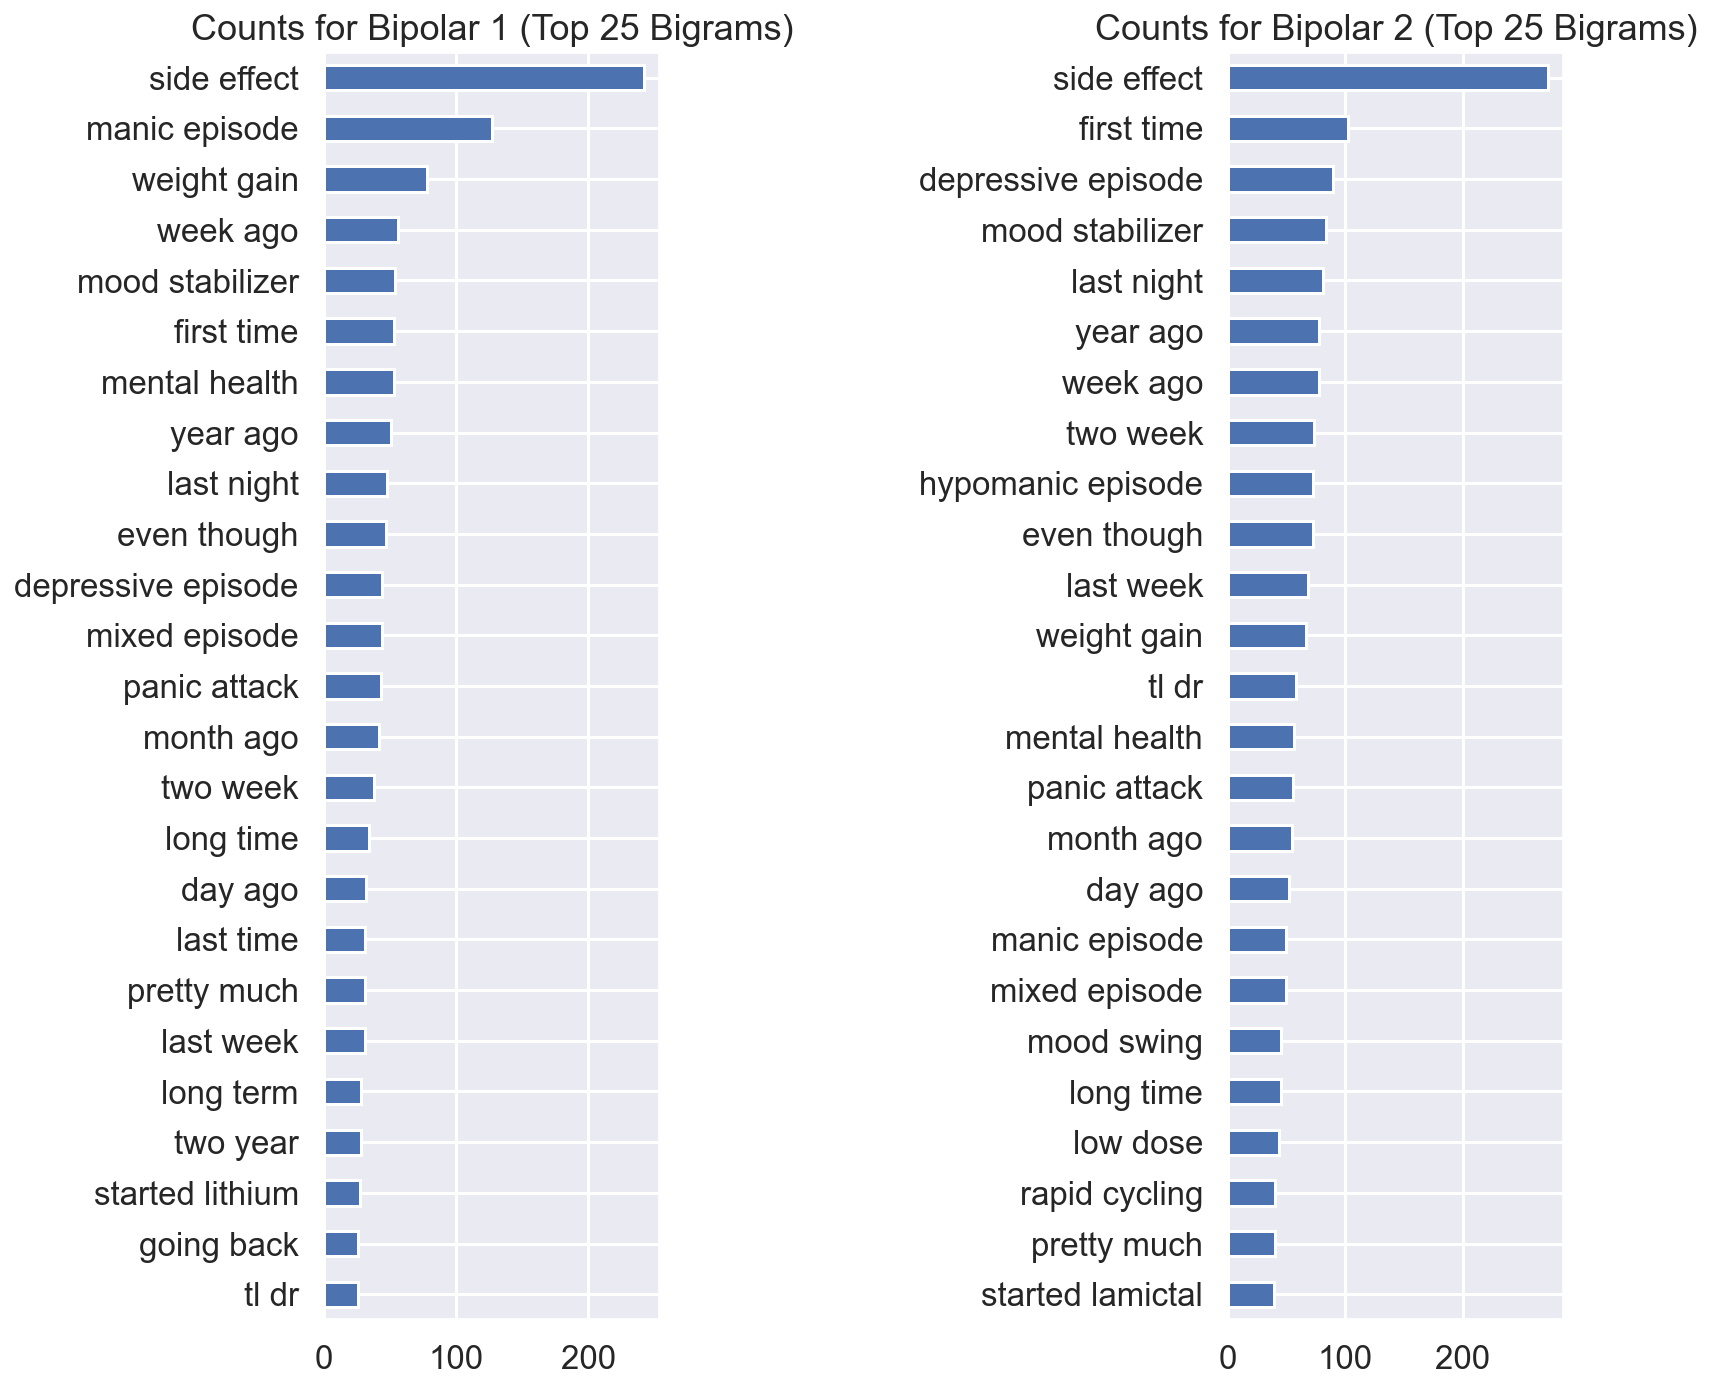

In [66]:
# Create an instance of CountVectorizer and pass in the clean_text function as the analyzer parameter
count_vect = CountVectorizer(ngram_range=(2,2), max_features=100)

fig, axs = plt.subplots(nrows=1, ncols=2)
plt.subplot(1, 2, 1)
word_chart(count_vect, bp1['cleaned_text'], 'Counts for Bipolar 1 (Top 25 Bigrams)')
plt.subplot(1, 2, 2)
word_chart(count_vect, bp2['cleaned_text'], 'Counts for Bipolar 2 (Top 25 Bigrams)')
fig.tight_layout()
fig.set_size_inches(13, 10)

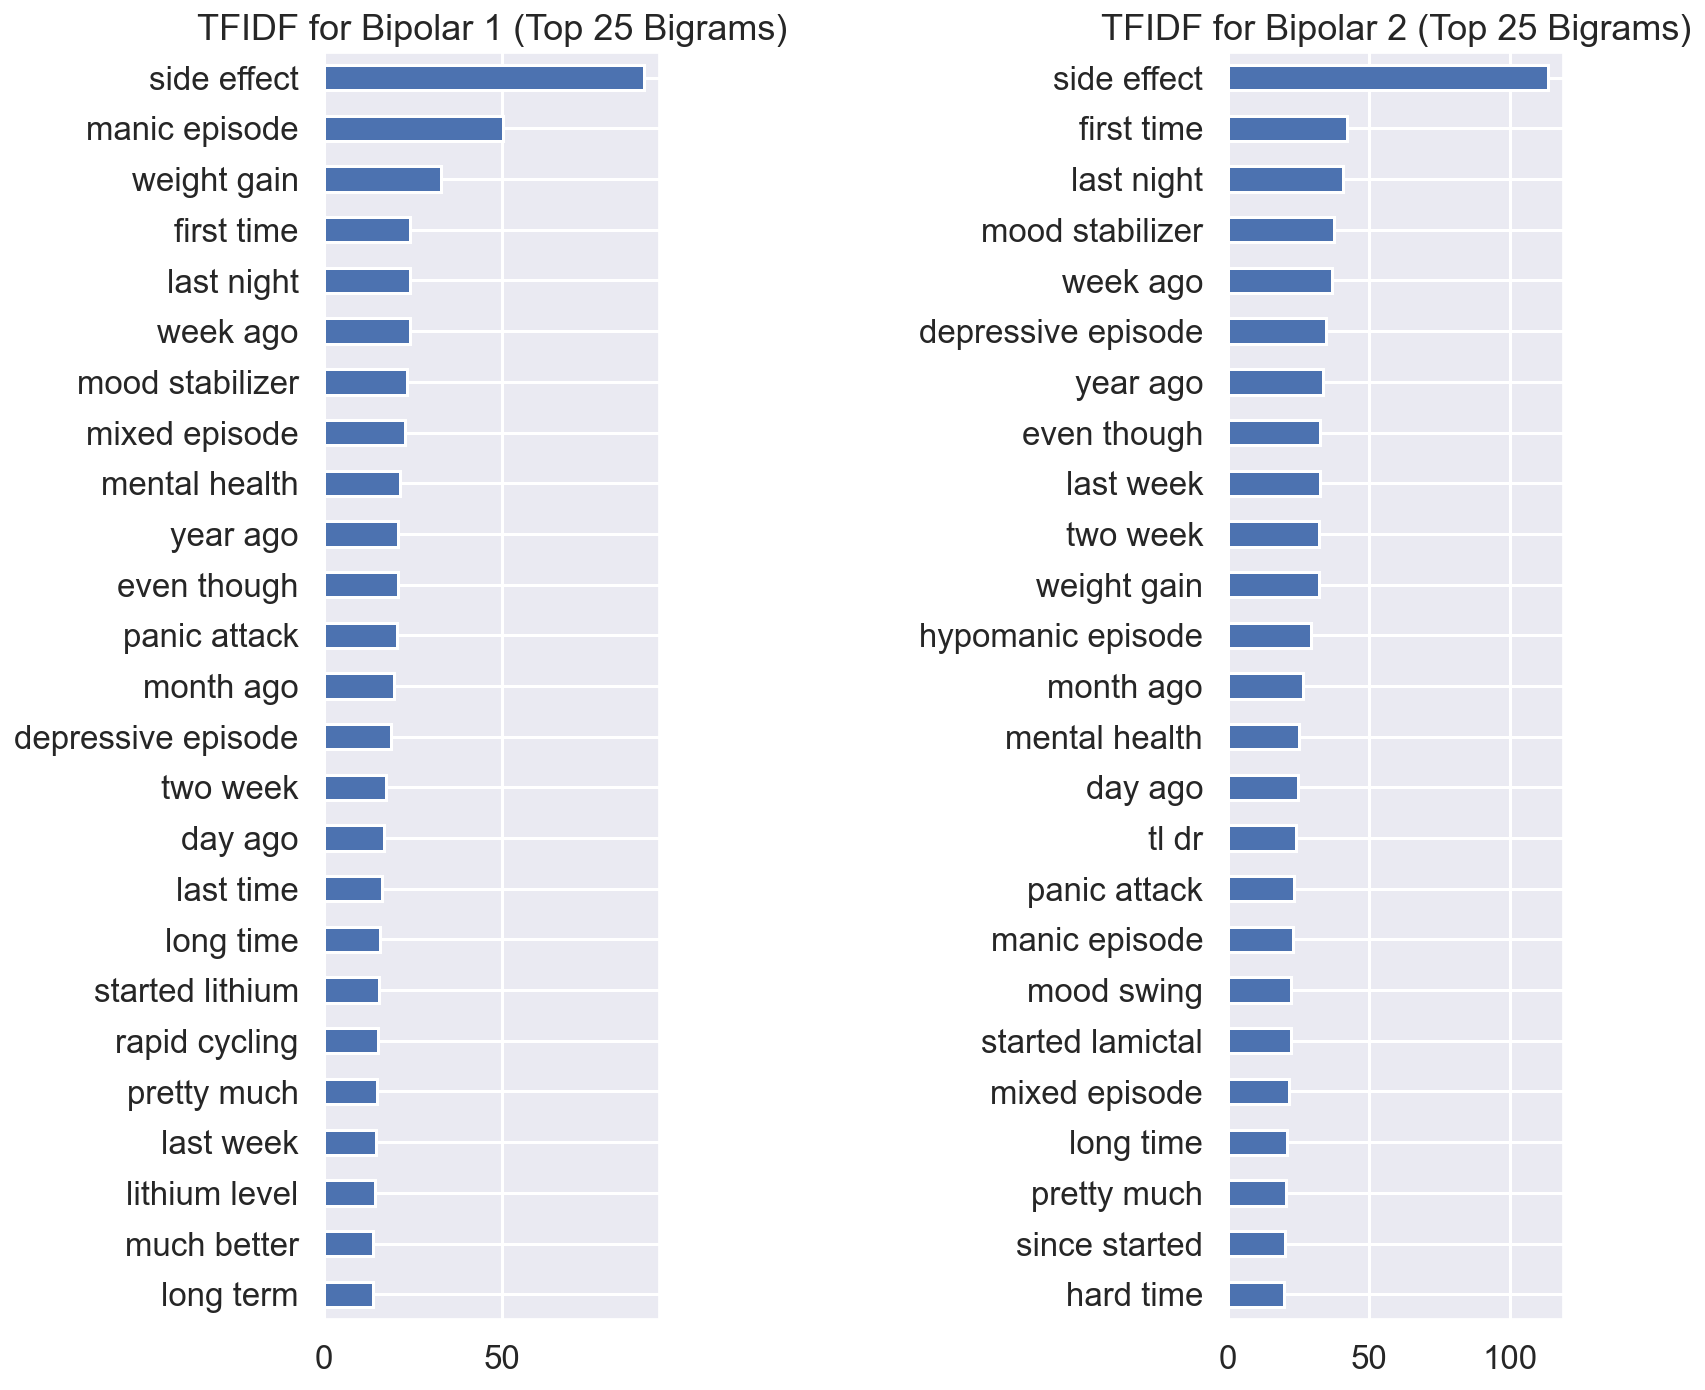

In [67]:
# Create an instance of TfidfVectorizer and pass in the clean_text function as the analyzer parameter
tfidf_vect = TfidfVectorizer(ngram_range=(2,2), max_features=100)

fig, axs = plt.subplots(nrows=1, ncols=2)
plt.subplot(1, 2, 1)
word_chart(tfidf_vect, bp1['cleaned_text'], 'TFIDF for Bipolar 1 (Top 25 Bigrams)')
plt.subplot(1, 2, 2)
word_chart(tfidf_vect, bp2['cleaned_text'], 'TFIDF for Bipolar 2 (Top 25 Bigrams)')
fig.tight_layout()
fig.set_size_inches(13, 10)

Both vectorisation methods produced similar results. Here we are able to obtain more insight. We see that both subtypes are predominantly concerned about side effects. Also, they seek advice on the subreddit about the first time they had an experience with the medications. Weight gain can be observed as a side effect that users are highly concerned about. Hypomania is specific to Type 2, and hence, we see it mentioned.

## Mentions of mood stabilisers 

Now, we will bin the data into posts that mention each of the 3 mood stabilisers being studied. One post can mention more than one mood stabilier, so the bins are not mutually exclusive. We will create a column for each mood stabiliser. A '1' in the column indicates that the post has mentioned the particular mood stabiliser. 

In [68]:
sb.loc[(sb['text'].str.contains('lithium', case=False)), 'lithium_'] = 1
sb.loc[(~sb['text'].str.contains('lithium', case=False)), 'lithium_'] = 0

sb.loc[(sb['text'].str.contains('lamotrigine|lamictal', regex=True, case=False)), 'lamotrigine_'] = 1
sb.loc[(~sb['text'].str.contains('lamotrigine|lamictal', regex=True, case=False)), 'lamotrigine_'] = 0

sb.loc[(sb['text'].str.contains('seroquel|quetiapine', regex=True, case=False)), 'quetiapine_'] = 1
sb.loc[(~sb['text'].str.contains('seroquel|quetiapine', regex=True, case=False)), 'quetiapine_'] = 0

Now, the new columns will be checked:

In [69]:
sb['lithium_'].value_counts()

0.0    1530
1.0     970
Name: lithium_, dtype: int64

In [70]:
sb['lamotrigine_'].value_counts()

1.0    1291
0.0    1209
Name: lamotrigine_, dtype: int64

In [71]:
sb['quetiapine_'].value_counts()

0.0    1770
1.0     730
Name: quetiapine_, dtype: int64

The TFIDF analyses will now be plotted for each mood stabiliser.

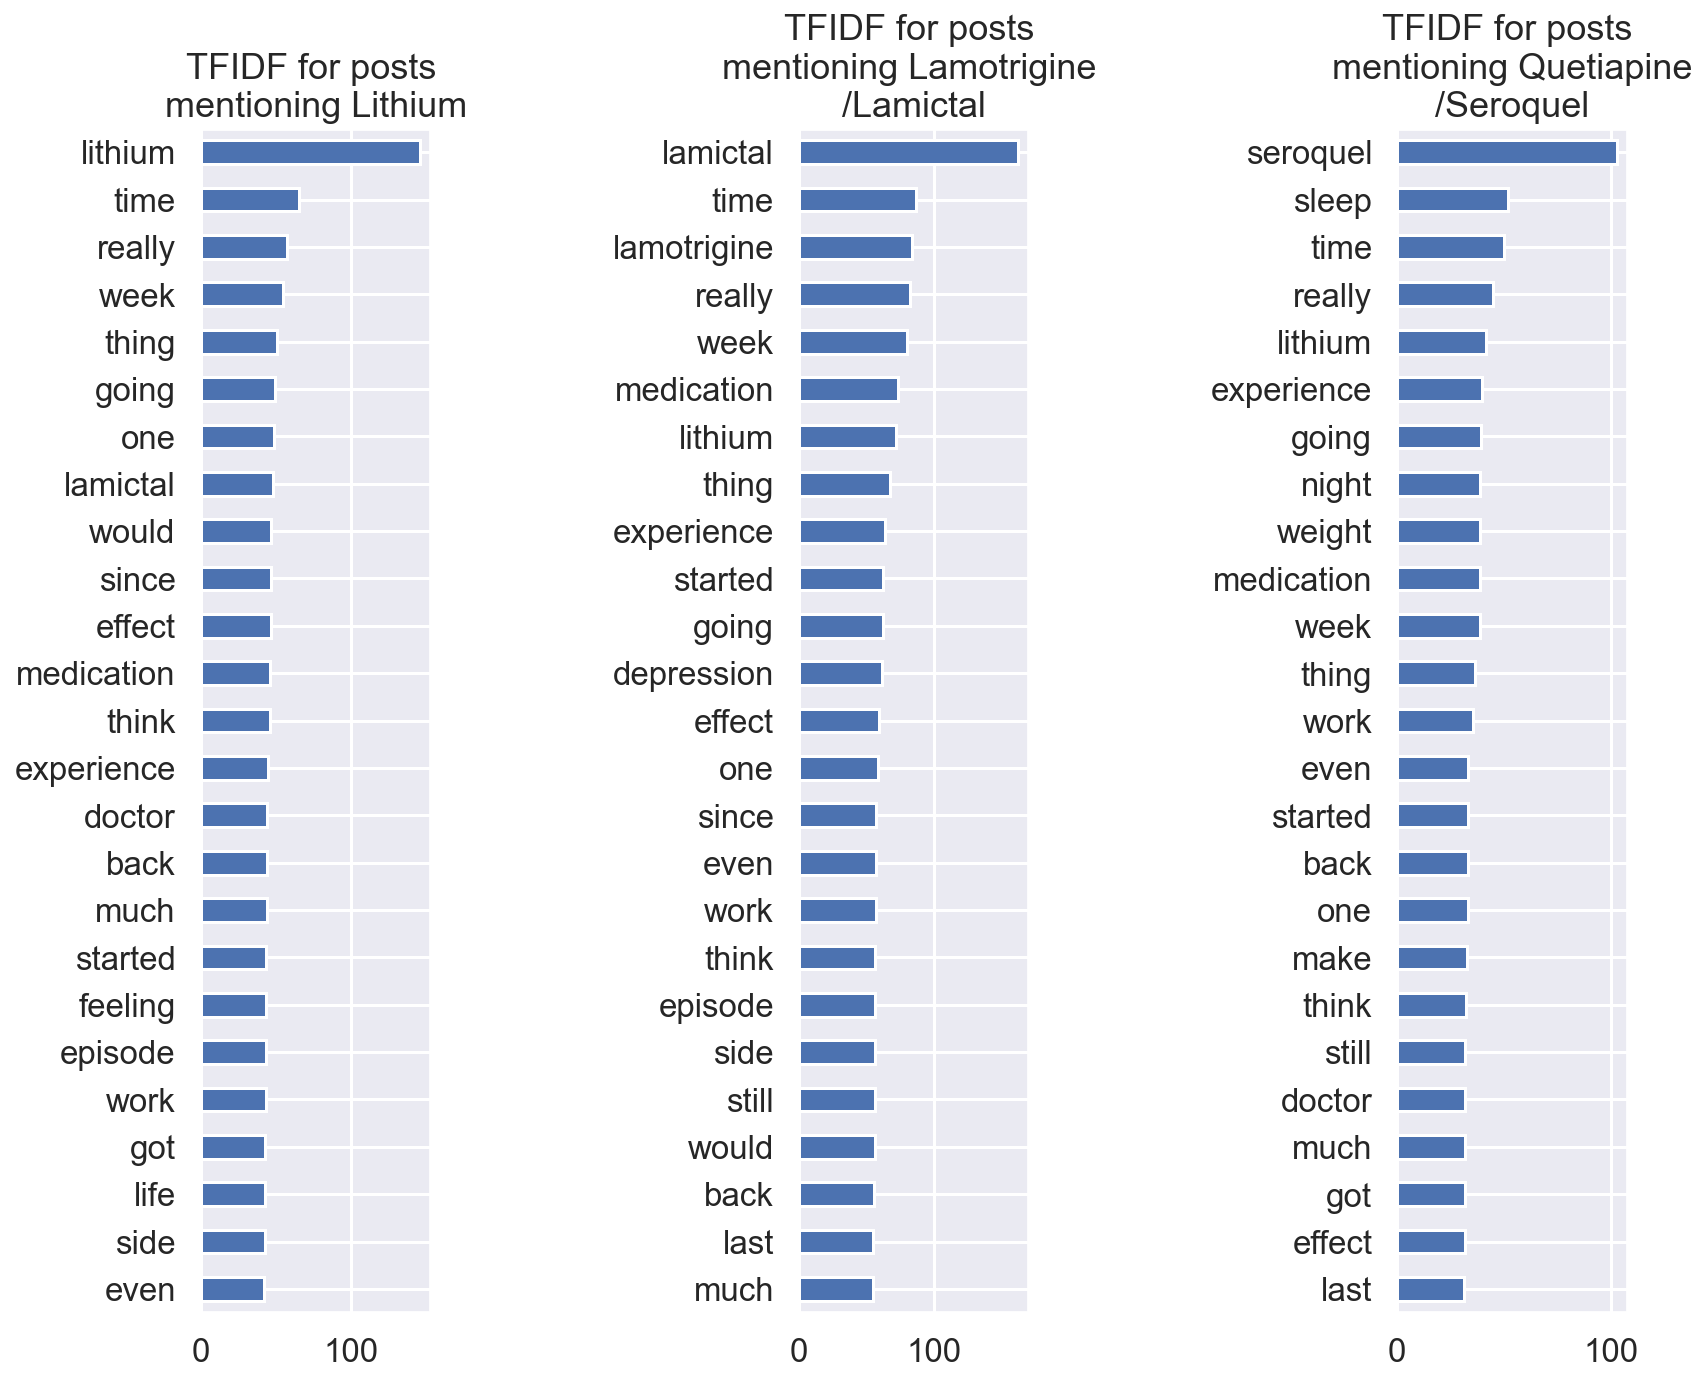

In [72]:
# Create an instance of TFIDFVectorizer and pass in the clean_text function as the analyzer parameter
tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=100)

# Specify DataFrames for each mood stabiliser using the new column
li = sb[sb['lithium_'] == 1]
la = sb[sb['lamotrigine_'] == 1]
qu = sb[sb['quetiapine_'] == 1]

# Create a figure with 3 subplots, one for each mood stabiliser
fig, axs = plt.subplots(nrows=1, ncols=3)
plt.subplot(1, 3, 1)
word_chart(tfidf_vect, li['text'], 'TFIDF for posts \nmentioning Lithium')
plt.subplot(1, 3, 2)
word_chart(tfidf_vect, la['text'], 'TFIDF for posts \nmentioning Lamotrigine \n/Lamictal')
plt.subplot(1, 3, 3)
word_chart(tfidf_vect, qu['text'], 'TFIDF for posts \nmentioning Quetiapine\n/Seroquel')
fig.tight_layout()
fig.set_size_inches(13, 10);

Here, we can see that posts that mention lithium also mention Lamictal, and Posts that mention Lamictal also mention lithium as well. Posts that mention quetiapine use the name Seroquel to refer to the drug, and these posts mention lithium as well. These relationsips would mean that the Reddit users could either be seeking advice on the alternative drug, or they could be taking both the drugs. We can generally say that the users are seeking advice seriously on the medications. Also, the words that appeared for Seroquel include 'sleep' and 'weight'. Daytime sleepiness and weight gain are known common side effects of Seroquel ([*source*](https://www.webmd.com/drugs/2/drug-4718/seroquel-oral/details/list-sideeffects)). Hence, they could be seeking for advice on how to deal with side effects. We can check the data itself:

In [81]:
qu[qu['text'].str.contains('sleep')]['text'].head()

633                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Has Abilify affected your sleep? So I posted about Seroquel making me too tired. Has anyone had this problem with A

It seems that the assumption was correct.

In [83]:
qu[qu['text'].str.contains('weight')]['text'].head()

83                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Is it possible to gain weight from Seroquel only a week after it’s being increased? I gained 6 pounds in one week. I don’t understand because I feel like I am eating the exact same. Also, I am actually excessing more. The only thing that is different is that my Seroquel increased by 150mg. So now I’m taking 200mg. Please give advice, I really want to be proactive in making sure I don’t gain weight. I will stop the medication if this side effect h

The assumption on weight gain was also correct.

## Saving the DataFrame 

The DataFrame with the new columns will be saved to a .csv file.

In [84]:
sb.to_csv('../data/sb.csv', index=False)

The modelling will be continued in the next notebook.